# Predicting Crime Rates in the San Francisco Bay Area

As a recent transplant from southern CA to the San Francisco Bay Area, one of the more notable differences is the seemingly open crime.  I thought it would be interesting to gather and analyze publicly-available crime data for the region to identify any notable trends, and combine socioeconomic and demographic data to determine which factors are associated with higher/lower per-capita crime rates, and which may be used to train a model to predict per-capita crime rates in the Bay Area.

# Data Collection + Cleaning

Data were collected from 2 primary sources:

* [CA Department of Justics - Crimes and Clearances](https://openjustice.doj.ca.gov/data)
    * Monthly crime data reported by law enforcement agencies (LEAs) throughout the state as part of the FBI's Uniform Crime Reporting Program.  The information is used to provide statistical data on the offenses of: criminal homicide, rape, robbery, aggravated assault, burglary, larceny-theft, motor vehicle theft, and arson.



* [US Census Bureau](https://data.census.gov) (tables below):
    * **S1901** - Income in the Past 12 Months (in 2021 inflation-adjusted dollars)
    * **S1501** - Educational Attainment
    * **DP01** - Decennial Census: Profile of General Population and Housing Characteristics (2020)
    * **DO03** - Selected Economic Characteristics
    * **DP02** - Selected Social Characteristics
    * Census data were pulled for the [9 counties and 101 distinct municipalities](http://www.bayareacensus.ca.gov/cities/cities.htm) of the Bay Area. 

In [1]:
# import dependencies

import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
# import os
import math


from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import mean_squared_error

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## I. Demographic data

In [2]:
def read_file(file_name):
    df = pd.read_csv(file_name)
    return df

In [3]:
# investigate county-level US Census demographic data

# Begin with Alameda County

df = read_file('demographics/demographics_alameda county_2020.csv')
df.head(50)

,Label (Grouping),Alameda city; California!!Count,Alameda city; California!!Percent,Albany city; California!!Count,Albany city; California!!Percent,Berkeley city; California!!Count,Berkeley city; California!!Percent,Dublin city; California!!Count,Dublin city; California!!Percent,Emeryville city; California!!Count,Emeryville city; California!!Percent,Fremont city; California!!Count,Fremont city; California!!Percent,Hayward city; California!!Count,Hayward city; California!!Percent,Livermore city; California!!Count,Livermore city; California!!Percent,Newark city; California!!Count,Newark city; California!!Percent,Oakland city; California!!Count,Oakland city; California!!Percent,Piedmont city; California!!Count,Piedmont city; California!!Percent,Pleasanton city; California!!Count,Pleasanton city; California!!Percent,San Leandro city; California!!Count,San Leandro city; California!!Percent
0,SEX AND AGE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Total population,"78,280",100.0%,"20,271",100.0%,"124,321",100.0%,"72,589",100.0%,"12,905",100.0%,"230,504",100.0%,"162,954",100.0%,"87,955",100.0%,"47,529",100.0%,"440,646",100.0%,"11,270",100.0%,"79,871",100.0%,"91,008",100.0%
2,Under 5 years,"4,118",5.3%,"1,057",5.2%,"4,097",3.3%,"4,900",6.8%,578,4.5%,"13,494",5.9%,"9,387",5.8%,"5,000",5.7%,"3,179",6.7%,"23,210",5.3%,487,4.3%,"3,543",4.4%,"4,562",5.0%
3,5 to 9 years,"4,493",5.7%,"1,217",6.0%,"4,082",3.3%,"5,965",8.2%,343,2.7%,"16,059",7.0%,"9,439",5.8%,"5,496",6.2%,"2,597",5.5%,"23,364",5.3%,815,7.2%,"5,146",6.4%,"4,592",5.0%
4,10 to 14 years,"4,449",5.7%,"1,317",6.5%,"4,352",3.5%,"5,472",7.5%,321,2.5%,"15,691",6.8%,"9,986",6.1%,"5,623",6.4%,"2,490",5.2%,"23,880",5.4%,"1,045",9.3%,"6,452",8.1%,"5,076",5.6%
5,15 to 19 years,"4,047",5.2%,"1,989",9.8%,"12,921",10.4%,"4,127",5.7%,266,2.1%,"13,444",5.8%,"10,310",6.3%,"5,456",6.2%,"2,582",5.4%,"22,552",5.1%,930,8.3%,"6,014",7.5%,"5,162",5.7%
6,20 to 24 years,"3,773",4.8%,"1,181",5.8%,"21,960",17.7%,"3,143",4.3%,924,7.2%,"11,419",5.0%,"11,711",7.2%,"4,583",5.2%,"2,668",5.6%,"24,267",5.5%,474,4.2%,"3,847",4.8%,"5,397",5.9%
7,25 to 29 years,"4,641",5.9%,"1,436",7.1%,"11,848",9.5%,"4,321",6.0%,"1,876",14.5%,"14,487",6.3%,"13,299",8.2%,"5,007",5.7%,"3,701",7.8%,"38,443",8.7%,298,2.6%,"3,722",4.7%,"6,569",7.2%
8,30 to 34 years,"5,629",7.2%,"1,555",7.7%,"9,351",7.5%,"6,153",8.5%,"2,146",16.6%,"18,337",8.0%,"14,123",8.7%,"6,207",7.1%,"4,843",10.2%,"45,860",10.4%,285,2.5%,"4,178",5.2%,"7,011",7.7%
9,35 to 39 years,"6,197",7.9%,"1,416",7.0%,"7,271",5.8%,"7,955",11.0%,"1,475",11.4%,"20,383",8.8%,"12,822",7.9%,"6,674",7.6%,"4,198",8.8%,"40,381",9.2%,483,4.3%,"5,384",6.7%,"6,272",6.9%


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Data columns (total 27 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   Label (Grouping)                       174 non-null    object
 1   Alameda city; California!!Count        160 non-null    object
 2   Alameda city; California!!Percent      160 non-null    object
 3   Albany city; California!!Count         160 non-null    object
 4   Albany city; California!!Percent       160 non-null    object
 5   Berkeley city; California!!Count       160 non-null    object
 6   Berkeley city; California!!Percent     160 non-null    object
 7   Dublin city; California!!Count         160 non-null    object
 8   Dublin city; California!!Percent       160 non-null    object
 9   Emeryville city; California!!Count     160 non-null    object
 10  Emeryville city; California!!Percent   160 non-null    object
 11  Fremont city; Calif

The raw county-level data tables are messy, with missing values, numerical values stored as text and formatting that is not conducive to analysis - cleaning is required to prepare the data for exploration and analysis.

In [5]:
# rename columns

## iterate thru the column names, parse out the city name (all text until the first '!'), and use that to rename the columns

# create a tracker that iterates thru the columns and tracks which column indexes to delete based on the text in the column

def remove_columns(df, match_terms):
    tracker = []
    idx = 0

    # establish match terms
    # match_terms = ['Percent', 'Margin of Error', 'Male', 'Female']

    # if our match terms of interest are in the column name, flag that column for removal by adding to the tracker

    for col_name in df:

        #print(row[0])
        for term in match_terms:
            if term in col_name:
                # print('Match: ', col_name, ' and ', term, ' and ',idx)
                # continue
                if col_name not in tracker:
                    #tracker.append(ind)
                    tracker.append(col_name)
                    
    df.drop(tracker, axis=1, inplace=True)
    return df

In [6]:
# rename columns to reflect the city and population of interest

# we want to take all the text up through the comma, parse that out
# then take the last word (beyond the !!) and remove that, and parse out the term just before
# likely use regex for expression matching to identify location within the string to extract text

def rename_columns(df):
    
    master_tracker = []

    for item in df:

        item_split = re.split(r'!!', item)
        master_tracker.append(item_split)
    
    label_tracker = []
    for label in master_tracker[1:]:
        city = re.split(r',', label[0])[0][:-5]
        label_tracker.append(city)
    # print(label_tracker)
    
    new_dict = {}
    idx=0

    for col_old in df:
        new_dict[col_old] = label_tracker[idx-1]
        idx += 1

    del new_dict['Label (Grouping)']
    df.rename(columns = new_dict, inplace=True)
    return df

In [7]:
def rename_columns_demo(df):
    
    master_tracker = []

    for item in df:

        item_split = re.split(r'!!', item)
        master_tracker.append(item_split)
    
    label_tracker = []
    for label in master_tracker[1:]:
        city = re.split(r';', label[0])[0][:-5]
        label_tracker.append(city)
    # print(label_tracker)
    
    new_dict = {}
    idx=0

    for col_old in df:
        new_dict[col_old] = label_tracker[idx-1]
        idx += 1

    del new_dict['Label (Grouping)']
    df.rename(columns = new_dict, inplace=True)
    return df

In [8]:
def transpose_df(df):
    transposed_df = df.set_index('Label (Grouping)').transpose().reset_index()
    transposed_df.rename(columns = {'index': 'City'}, inplace=True)
    return transposed_df

In [9]:
# file_name = 'demographics/demographics_alameda county_2020.csv'

# iterate through each county-level file and perform the necessary steps to output a clean file containing data from all counties

file_list = [
    ['demographics/demographics_alameda county_2020.csv', 'Alameda County'],
    ['demographics/demographics_contra costa county_2020.csv', 'Contra Costa County'],
    ['demographics/demographics_marin county_2020.csv', 'Marin County'],
    ['demographics/demographics_napa county_2020.csv', 'Napa County'],
    ['demographics/demographics_san francisco_2020.csv', 'San Francisco County'],
    ['demographics/demographics_san mateo county_2020.csv', 'San Mateo County'],
    ['demographics/demographics_santa clara county_2020.csv', 'Santa Clara County'],
    ['demographics/demographics_solano county_2020.csv', 'Solano County'],
    ['demographics/demographics_sonoma county_2020.csv', 'Sonoma County']
]

def clean_demographic_file(file_list):
    
    match_terms = ['Percent']
    
    df_master = read_file(file_list[0][0])
    df_master = remove_columns(df_master, match_terms)
    df_master = rename_columns_demo(df_master)
    df_master = transpose_df(df_master)
    df_master['County'] = file_list[0][1]
    
    for file in file_list[1:]:
        df = read_file(file[0])
        df = remove_columns(df, match_terms)
        df = rename_columns_demo(df)
        df = transpose_df(df)
        df['County'] = file[1]
        
        df_master = pd.concat([df_master, df])
    
    df_master.to_csv('02_demo_clean input for PowerBI.csv')
    # consolidated_df.to_csv('01_education_clean input for PowerBI.csv')
    
    
clean_demographic_file(file_list)

In [10]:
demographics = pd.read_csv('demographics_clean.csv', encoding='windows-1252')
demographics.head()

,Column1,City,Total population,Under 5 years,5 to 9 years,10 to 14 years,15 to 19 years,20 to 24 years,25 to 29 years,30 to 34 years,35 to 39 years,40 to 44 years,45 to 49 years,50 to 54 years,55 to 59 years,60 to 64 years,65 to 69 years,70 to 74 years,75 to 79 years,80 to 84 years,85 years and over,16 years and over,18 years and over,21 years and over,62 years and over,65 years and over,Â Â Â Â Male population,Male - Under 5 years,Male - 5 to 9 years,Male - 10 to 14 years,Male - 15 to 19 years,Male - 20 to 24 years,Male - 25 to 29 years,Male - 30 to 34 years,Male - 35 to 39 years,Male - 40 to 44 years,Male - 45 to 49 years,Male - 50 to 54 years,Male - 55 to 59 years,Male - 60 to 64 years,Male - 65 to 69 years,Male - 70 to 74 years,Male - 75 to 79 years,Male - 80 to 84 years,Male - 85 years and over,Female population,Female - Under 5 years,Female - 5 to 9 years,Female - 10 to 14 years,Female - 15 to 19 years,Female - 20 to 24 years,Female - 25 to 29 years,Female - 30 to 34 years,Female - 35 to 39 years,Female - 40 to 44 years,Female - 45 to 49 years,Female - 50 to 54 years,Female - 55 to 59 years,Female - 60 to 64 years,Female - 65 to 69 years,Female - 70 to 74 years,Female - 75 to 79 years,Female - 80 to 84 years,Female - 85 years and over,Median Age_Both sexes,Median Age_Male,Median Age_Female,White,Black or African American,American Indian and Alaska Native,Asian,Native Hawaiian and Other Pacific Islander,Some Other Race,Two or More Races,County
0,0,Alameda,78280,4118,4493,4449,4047,3773,4641,5629,6197,5748,5911,5527,5124,4912,4507,3649,2308,1472,1775,64341,62671,60466,16563,13711,37328,2104,2275,2290,2107,1916,2304,2742,2926,2715,2699,2622,2389,2265,2111,1657,991,590,625,40952,2014,2218,2159,1940,1857,2337,2887,3271,3033,3212,2905,2735,2647,2396,1992,1317,882,1150,41.4,40.0,42.9,34102,4608,441,25412,399,3244,10074,Alameda County
1,1,Albany,20271,1057,1217,1317,1989,1181,1436,1555,1416,1398,1424,1235,1054,956,961,914,507,278,376,16400,15889,14403,3618,3036,9657,540,626,683,982,590,700,758,673,649,661,576,494,418,416,414,203,124,150,10614,517,591,634,1007,591,736,797,743,749,763,659,560,538,545,500,304,154,226,36.3,34.6,37.8,9446,716,90,6184,17,1131,2687,Alameda County
2,2,Berkeley,124321,4097,4082,4352,12921,21960,11848,9351,7271,6252,6085,5790,5827,5559,5539,5612,3780,2088,1907,110797,108927,92716,22174,18926,60913,2093,2048,2272,5994,10919,5984,4847,3645,3032,3097,2903,2866,2677,2628,2567,1690,937,714,63408,2004,2034,2080,6927,11041,5864,4504,3626,3220,2988,2887,2961,2882,2911,3045,2090,1151,1193,31.3,30.9,31.7,66267,9812,653,24896,265,7848,14580,Alameda County
3,3,Dublin,72589,4900,5965,5472,4127,3143,4321,6153,7955,7441,6057,4475,3712,2896,2038,1667,1111,668,488,55314,53504,51517,7707,5972,34737,2453,2992,2806,2112,1523,2087,2716,3556,3619,3091,2116,1715,1342,920,722,471,308,188,37852,2447,2973,2666,2015,1620,2234,3437,4399,3822,2966,2359,1997,1554,1118,945,640,360,300,36.4,36.0,36.8,21105,2876,517,39077,221,2642,6151,Alameda County
4,4,Emeryville,12905,578,343,321,266,924,1876,2146,1475,944,753,627,585,559,464,393,309,175,167,11612,11510,11292,1831,1508,6278,286,165,182,138,409,911,1110,761,491,370,314,283,244,190,173,124,71,56,6627,292,178,139,128,515,965,1036,714,453,383,313,302,315,274,220,185,104,111,35.0,34.7,35.4,4796,2015,76,3965,54,617,1382,Alameda County


In [11]:
demographics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 75 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Column1                                     99 non-null     int64  
 1   City                                        99 non-null     object 
 2   Total population                            99 non-null     int64  
 3   Under 5 years                               99 non-null     int64  
 4   5 to 9 years                                99 non-null     int64  
 5   10 to 14 years                              99 non-null     int64  
 6   15 to 19 years                              99 non-null     int64  
 7   20 to 24 years                              99 non-null     int64  
 8   25 to 29 years                              99 non-null     int64  
 9   30 to 34 years                              99 non-null     int64  
 10  35 to 39 years  

The demographic data have now been cleaned, converted to integer/float values, combined into one master table and organized at a city-level  for each Bay Area city (where available).

## II. Education data



In [12]:
# investigate county-level US Census education data

# Begin with Alameda County

education = pd.read_csv('education/educational attainment_alameda county_2021.csv')
education.head()

,Label (Grouping),"Alameda city, California!!Total!!Estimate","Alameda city, California!!Total!!Margin of Error","Alameda city, California!!Percent!!Estimate","Alameda city, California!!Percent!!Margin of Error","Alameda city, California!!Male!!Estimate","Alameda city, California!!Male!!Margin of Error","Alameda city, California!!Percent Male!!Estimate","Alameda city, California!!Percent Male!!Margin of Error","Alameda city, California!!Female!!Estimate","Alameda city, California!!Female!!Margin of Error","Alameda city, California!!Percent Female!!Estimate","Alameda city, California!!Percent Female!!Margin of Error","Berkeley city, California!!Total!!Estimate","Berkeley city, California!!Total!!Margin of Error","Berkeley city, California!!Percent!!Estimate","Berkeley city, California!!Percent!!Margin of Error","Berkeley city, California!!Male!!Estimate","Berkeley city, California!!Male!!Margin of Error","Berkeley city, California!!Percent Male!!Estimate","Berkeley city, California!!Percent Male!!Margin of Error","Berkeley city, California!!Female!!Estimate","Berkeley city, California!!Female!!Margin of Error","Berkeley city, California!!Percent Female!!Estimate","Berkeley city, California!!Percent Female!!Margin of Error","Dublin city, California!!Total!!Estimate","Dublin city, California!!Total!!Margin of Error","Dublin city, California!!Percent!!Estimate","Dublin city, California!!Percent!!Margin of Error","Dublin city, California!!Male!!Estimate","Dublin city, California!!Male!!Margin of Error","Dublin city, California!!Percent Male!!Estimate","Dublin city, California!!Percent Male!!Margin of Error","Dublin city, California!!Female!!Estimate","Dublin city, California!!Female!!Margin of Error","Dublin city, California!!Percent Female!!Estimate","Dublin city, California!!Percent Female!!Margin of Error","Fremont city, California!!Total!!Estimate","Fremont city, California!!Total!!Margin of Error","Fremont city, California!!Percent!!Estimate","Fremont city, California!!Percent!!Margin of Error","Fremont city, California!!Male!!Estimate","Fremont city, California!!Male!!Margin of Error","Fremont city, California!!Percent Male!!Estimate","Fremont city, California!!Percent Male!!Margin of Error","Fremont city, California!!Female!!Estimate","Fremont city, California!!Female!!Margin of Error","Fremont city, California!!Percent Female!!Estimate","Fremont city, California!!Percent Female!!Margin of Error","Hayward city, California!!Total!!Estimate","Hayward city, California!!Total!!Margin of Error","Hayward city, California!!Percent!!Estimate","Hayward city, California!!Percent!!Margin of Error","Hayward city, California!!Male!!Estimate","Hayward city, California!!Male!!Margin of Error","Hayward city, California!!Percent Male!!Estimate","Hayward city, California!!Percent Male!!Margin of Error","Hayward city, California!!Female!!Estimate","Hayward city, California!!Female!!Margin of Error","Hayward city, California!!Percent Female!!Estimate","Hayward city, California!!Percent Female!!Margin of Error","Livermore city, California!!Total!!Estimate","Livermore city, California!!Total!!Margin of Error","Livermore city, California!!Percent!!Estimate","Livermore city, California!!Percent!!Margin of Error","Livermore city, California!!Male!!Estimate","Livermore city, California!!Male!!Margin of Error","Livermore city, California!!Percent Male!!Estimate","Livermore city, California!!Percent Male!!Margin of Error","Livermore city, California!!Female!!Estimate","Livermore city, California!!Female!!Margin of Error","Livermore city, California!!Percent Female!!Estimate","Livermore city, California!!Percent Female!!Margin of Error","Oakland city, California!!Total!!Estimate","Oakland city, California!!Total!!Margin of Error","Oakland city, California!!Percent!!Estimate","Oakland city, California!!Percent!!Margin of Error","Oakland city, California!!Male!!Estimate","Oakland city, California!!Male!!Margin of Error","Oakland city, California!!Percent 

In [13]:
education.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Columns: 109 entries, Label (Grouping) to San Leandro city, California!!Percent Female!!Margin of Error
dtypes: object(109)
memory usage: 58.0+ KB


In [14]:
#transpose df

def transpose_df_edu(df):
    transposed_df = df.set_index('Label (Grouping)').transpose().reset_index()
    transposed_df.rename(columns = {'index': 'City'}, inplace=True)
    
    #removes columns we don't care about from the educational files
    transposed_df = transposed_df.iloc[:,:29]
    
    return transposed_df

    # transposed_df.to_csv('01_education_clean input for PowerBI.csv')

In [15]:
file_list = [
    ['education/educational attainment_alameda county_2021.csv', 'Alameda County'],
    ['education/educational attainment_contra costa county_2021.csv', 'Contra Costa County'],
    ['education/educational attainment_marin county_2021.csv', 'Marin County'],
    ['education/educational attainment_napa county_2021.csv', 'Napa County'],
    ['education/educational attainment_san francisco_2021.csv', 'San Francisco County'],
    ['education/educational attainment_san mateo county_2021.csv', 'San Mateo County'],
    ['education/educational attainment_santa clara county_2021.csv', 'Santa Clara County'],
    ['education/educational attainment_solano county_2021.csv', 'Solano County'],
    ['education/educational attainment_sonoma county_2021.csv', 'Sonoma County']
]

def clean_education_file(file_list):
    
    match_terms = ['Percent', 'Margin of Error', 'Male', 'Female']
    
    df_master = read_file(file_list[0][0])
    df_master = remove_columns(df_master, match_terms)
    df_master = rename_columns(df_master)
    df_master = transpose_df_edu(df_master)
    df_master['County'] = file_list[0][1]
    
    for file in file_list[1:]:
        df = read_file(file[0])
        df = remove_columns(df, match_terms)
        df = rename_columns(df)
        df = transpose_df_edu(df)
        df['County'] = file[1]
        
        df_master = pd.concat([df_master, df])
    
    df_master.to_csv('01_education_clean input for PowerBI.csv')
    
clean_education_file(file_list)

In [16]:
education = pd.read_csv('education_clean.csv')
education.head()

,Column1,City,18 -24 Total Population,18-24 Less than high school graduate,18-24 High school graduate (includes equivalency),18-24 Some college or associate's degree,18-24 Bachelor's degree or higher,25+ Total Population,25+ Less than 9th grade,"25+ 9th to 12th grade, no diploma",25+ High school graduate (includes equivalency),"25+ Some college, no degree",25+ Associate's degree,25+ Bachelor's degree,25+ Graduate or professional degree,25+ High school graduate or higher,25+ Bachelor's degree or higher,25-34 Total Population,25-34 High school graduate or higher,25-34 Bachelor's degree or higher,35-44 Total Population,35-44 High school graduate or higher,35-44 Bachelor's degree or higher,45-64 Total Population,45-64 High school graduate or higher,45-64 Bachelor's degree or higher,65+ Total Population,65+ High school graduate or higher,65+ Bachelor's degree or higher,County
0,0,Alameda,3644,142,1754,1219,529,56820,1017,2134,6833,8758,3572,21549,12957,53669,34506,11547,11402,7892,12848,12454,8395,20195,19049,11800,12230,10764,6419,Alameda County
1,1,Berkeley,27072,597,7302,13263,5910,75318,1628,727,5372,9259,2835,24348,31149,72963,55497,21086,20709,17270,12683,12601,9555,23852,22520,16559,17697,17133,12113,Alameda County
2,2,Dublin,3276,47,1571,800,858,49204,1404,440,5109,5395,3614,18266,14976,47360,33242,9412,9126,6778,15913,15695,12199,16451,16280,11720,7428,6259,2545,Alameda County
3,3,Fremont,12766,823,3052,6375,2516,161130,4825,5271,23794,16229,8423,49371,53217,151034,102588,33362,32896,24130,41953,40750,31510,55643,52258,34353,30172,25130,12595,Alameda County
4,4,Hayward,11537,1622,4191,4958,766,114163,13795,7728,29291,19008,7825,25714,10802,92640,36516,27610,25871,12408,23371,19752,7857,40435,30236,11539,22747,16781,4712,Alameda County


In [17]:
education.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 30 columns):
 #   Column                                             Non-Null Count  Dtype 
---  ------                                             --------------  ----- 
 0   Column1                                            40 non-null     int64 
 1   City                                               40 non-null     object
 2   18 -24 Total Population                            40 non-null     int64 
 3   18-24 Less than high school graduate               40 non-null     int64 
 4   18-24 High school graduate (includes equivalency)  40 non-null     int64 
 5   18-24 Some college or associate's degree           40 non-null     int64 
 6   18-24 Bachelor's degree or higher                  40 non-null     int64 
 7   25+ Total Population                               40 non-null     int64 
 8   25+ Less than 9th grade                            40 non-null     int64 
 9   25+ 9th to 12th grade, 

# III. Social Data

In [18]:
file_list = [
            ['social/selected social characteristics_alameda county_2021.csv', 'Alameda County'],
            ['social/selected social characteristics_contra costa county_2021.csv', 'Contra Costa County'],
            ['social/selected social characteristics_marin county_2021.csv', 'Marin County'],
            ['social/selected social characteristics_napa county_2021.csv', 'Napa County'],
            ['social/selected social characteristics_san francisco_2021.csv', 'San Francisco County'],
            ['social/selected social characteristics_san mateo county_2021.csv', 'San Mateo County'],
            ['social/selected social characteristics_santa clara county_2021.csv', 'Santa Clara County'],
            ['social/selected social characteristics_solano county_2021.csv', 'Solano County'],
            ['social/selected social characteristics_sonoma county_2021.csv', 'Sonoma County']
            ]

def clean_social_file(file_list):
    
    match_terms = ['Margin of Error', 'Percent']
    
    df_master = read_file(file_list[0][0])
    df_master = remove_columns(df_master, match_terms)
    df_master = rename_columns(df_master)
    df_master = transpose_df(df_master)
    df_master['County'] = file_list[0][1]
    
    for file in file_list[1:]:
        
        df = read_file(file[0])
        df = remove_columns(df, match_terms)
        
        if re.match('.*marin', file[0]):
            df = rename_columns_demo(df)
        else:
            df = rename_columns(df)
        
        df = transpose_df(df)
        df['County'] = file[1]
        
        df_master = pd.concat([df_master, df])
    
    df_master.to_csv('03_social_clean input for PowerBI.csv')

clean_social_file(file_list)

In [19]:
social = pd.read_csv('social_clean.csv')
social.head()

,Column1,City,Total households,Average household size,Same house,Different house in the U.S.,Same county,Different county,Ancestry American,Ancestry Arab,Ancestry Czech,Ancestry Danish,Ancestry Dutch,Ancestry English,Ancestry French (except Basque),Ancestry French Canadian,Ancestry German,Ancestry Greek,Ancestry Hungarian,Ancestry Irish,Ancestry Italian,Ancestry Lithuanian,Ancestry Norwegian,Ancestry Polish,Ancestry Portuguese,Ancestry Russian,Ancestry Scotch-Irish,Ancestry Scottish,Ancestry Slovak,Ancestry Subsaharan African,Ancestry Swedish,Ancestry Swiss,Ancestry Ukrainian,Ancestry Welsh,Ancestry West Indian (excluding Hispanic origin groups),County
0,0,Alameda,30281,2.49,67186,8252,5144,3108,"1,982",344,361,318,455,"7,222",726,144,"5,783",450,277,"6,904","2,605",510,605,"2,485",544,"1,761",343,"1,551",0,485,448,145,628,599,71,Alameda County
1,1,Berkeley,43893,2.29,81595,30318,12921,17397,"2,698","1,714",338,274,646,"12,787","3,470",246,"9,855",743,817,"9,977","6,615",493,"1,340","2,721",994,"3,040",431,"1,748",97,"1,443","1,065","1,427","1,127",743,319,Alameda County
2,2,Dublin,23688,2.97,59674,10431,6133,4298,501,307,88,131,162,"4,066","1,411",45,"4,519",321,0,"3,144","3,330",45,"1,134",253,203,"1,693",110,"1,008",0,43,230,49,233,494,166,Alameda County
3,3,Fremont,75716,2.99,199703,23265,9774,13491,"3,176","3,470",50,296,478,"7,767","2,152",98,"8,422",291,124,"9,222","3,330",0,534,925,"1,940",580,793,"1,473",0,"1,199",731,184,84,467,267,Alameda County
4,4,Hayward,48619,3.23,144997,11944,8114,3830,"4,608","1,082",0,222,640,"2,490","1,180",113,"6,622",83,96,"3,083","3,350",69,332,"1,008","2,843",467,83,541,0,"1,822",563,94,453,300,78,Alameda County


In [20]:
social.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 36 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Column1                                                  39 non-null     int64  
 1   City                                                     39 non-null     object 
 2   Total households                                         39 non-null     int64  
 3   Average household size                                   39 non-null     float64
 4   Same house                                               39 non-null     int64  
 5   Different house in the U.S.                              39 non-null     int64  
 6   Same county                                              39 non-null     int64  
 7   Different county                                         39 non-null     int64  
 8   Ancestry American               

# IV. Economic Data

In [21]:
file_list = [
            ['economic/selected economic characteristics_alameda county_2021.csv', 'Alameda County'],
            ['economic/selected economic characteristics_contra costa county_2021.csv', 'Contra Costa County'],
            ['economic/selected economic characteristics_marin county_2021.csv', 'Marin County'],
            ['economic/selected economic characteristics_napa county_2021.csv', 'Napa County'],
            ['economic/selected economic characteristics_san francisco_2021.csv', 'San Francisco County'],
            ['economic/selected economic characteristics_san mateo county_2021.csv', 'San Mateo County'],
            ['economic/selected economic characteristics_santa clara county_2021.csv', 'Santa Clara County'],
            ['economic/selected economic characteristics_solano county_2021.csv', 'Solano County'],
            ['economic/selected economic characteristics_sonoma county_2021.csv', 'Sonoma County']
            ]

def clean_econ_file(file_list):
    
    match_terms = ['Margin of Error', 'Percent']
    
    df_master = read_file(file_list[0][0])
    df_master = remove_columns(df_master, match_terms)
    df_master = rename_columns(df_master)
    df_master = transpose_df(df_master)
    df_master['County'] = file_list[0][1]
    
    for file in file_list[1:]:
        
        df = read_file(file[0])
        df = remove_columns(df, match_terms)
        
        if re.match('.*marin', file[0]):
            df = rename_columns_demo(df)
        else:
            df = rename_columns(df)
        
        df = transpose_df(df)
        df['County'] = file[1]
        
        df_master = pd.concat([df_master, df])
    
    df_master.to_csv('04_econ_clean input for PowerBI.csv')

clean_econ_file(file_list)

In [22]:
economic = pd.read_csv('economic_clean.csv')
economic.head()

,City,Population 16 years and over,In labor force,Civilian labor force,Employed,Unemployed,Armed Forces,Not in labor force,Workers 16 years and over,"Car, truck, or van -- drove alone","Car, truck, or van -- carpooled",Public transportation (excluding taxicab),Walked,Other means,Worked from home,Mean travel time to work (minutes),Civilian employed population 16 years and over,"Agriculture, forestry, fishing and hunting, and mining",Construction,Manufacturing,Wholesale trade,Retail trade,"Transportation and warehousing, and utilities",Information,"Finance and insurance, and real estate and rental and leasing","Professional, scientific, and management, and administrative and waste management services","Educational services, and health care and social assistance","Arts, entertainment, and recreation, and accommodation and food services","Other services, except public administration",Public administration,Total households,"Less than $10,000","$10,000 to $14,999","$15,000 to $24,999","$25,000 to $34,999","$35,000 to $49,999","$50,000 to $74,999","$75,000 to $99,999","$100,000 to $149,999","$150,000 to $199,999","$200,000 or more",Median household income (dollars),Mean household income (dollars),With earnings,Mean earnings (dollars),With Social Security,Mean Social Security income (dollars),With retirement income,Mean retirement income (dollars),With Supplemental Security Income,Mean Supplemental Security Income (dollars),With cash public assistance income,Mean cash public assistance income (dollars),With Food Stamp/SNAP benefits in the past 12 months,County
0,Alameda,62106,41918,41322,38620,2702,596,20188,38053,18599,2166,2115,657,1061,13455,27.8,38620,251,1295,4227,525,2944,2223,1127,3107,6859,10237,2815,1221,1789,30281,958,486,1454,1494,2297,3557,3550,4316,3807,8362,115468,155556,24418,155725,7906,25021,6532,43954,1081,13996,1393,"7,085",2704,Alameda County
1,Berkeley,104883,65513,65513,59365,6148,0,39370,57877,17002,1654,2740,6073,3509,26899,24.1,59365,234,1760,2600,440,3884,1964,2743,3483,12413,21227,4631,2281,1705,43893,3166,1049,2197,2738,4059,4250,4298,6383,3951,11802,101048,152028,34185,154264,10422,24837,9622,44152,1208,8779,1126,"8,364",3639,Alameda County
2,Dublin,54715,38572,38524,37116,1408,48,16143,36915,14913,1522,571,639,675,18595,33.0,37116,0,798,4188,311,3718,1359,1577,2434,10837,7803,1916,860,1315,23688,481,303,211,607,645,1356,1731,2815,3243,12296,205219,221110,21819,221176,3776,21211,4205,41305,666,12367,1037,"7,376",1589,Alameda County
3,Fremont,180103,120383,120252,114961,5291,131,59720,112508,48581,4424,1893,766,1779,55065,27.6,114961,144,3258,17252,1587,7533,4283,5068,6857,36480,20701,4773,2828,4197,75716,2197,1599,2247,1996,2421,6427,6065,12994,11149,28621,155968,189180,65153,196351,17942,21598,14067,35062,3096,9197,4552,"5,013",3954,Alameda County
4,Hayward,129071,85086,84810,78612,6198,276,43985,75905,49264,7288,2178,864,708,15603,31.3,78612,192,6227,7974,1110,7959,8053,2285,3314,12424,18380,5913,2699,2082,48619,2761,1156,2511,2696,3157,6455,6425,9908,5276,8274,96386,120442,39960,121855,13711,19392,10686,26595,2747,10029,4378,"6,088",5308,Alameda County


In [23]:
economic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 55 columns):
 #   Column                                                                                      Non-Null Count  Dtype  
---  ------                                                                                      --------------  -----  
 0   City                                                                                        39 non-null     object 
 1   Population 16 years and over                                                                39 non-null     int64  
 2   In labor force                                                                              39 non-null     int64  
 3   Civilian labor force                                                                        39 non-null     int64  
 4   Employed                                                                                    39 non-null     int64  
 5   Unemployed                                   

# V. Income Data

Note: The data needed from this file is included in the econ file in a more usable format (raw figures vs percentage) so this data was ultimately not needed for the final table.

In [24]:
file_list = [
            ['income/income_alameda county_2021.csv', 'Alameda County'],
            ['income/income_contra costa county_2021.csv', 'Contra Costa County'],
            ['income/income_marin county_2021.csv', 'Marin County'], 
            ['income/income_napa county_2021.csv', 'Napa County'],
            ['income/income_san francisco_2021.csv', 'San Francisco County'],
            ['income/income_san mateo county_2021.csv', 'San Mateo County'],
            ['income/income_santa clara county_2021.csv', 'Santa Clara County'],
            ['income/income_solano county_2021.csv', 'Solano County'],
            ['income/income_sonoma county_2021.csv', 'Sonoma County']
            ]

def clean_income_file(file_list):
    
    match_terms = ['Margin of Error', 'Percent', 'Families', 'Married', 'Nonfamily']
    
    df_master = read_file(file_list[0][0])
    df_master = remove_columns(df_master, match_terms)
    df_master = rename_columns(df_master)
    df_master = transpose_df(df_master)
    df_master['County'] = file_list[0][1]
    
    for file in file_list[1:]:
        
        df = read_file(file[0])
        df = remove_columns(df, match_terms)
        
        if re.match('.*marin', file[0]):
            df = rename_columns_demo(df)
        else:
            df = rename_columns(df)
        
        df = transpose_df(df)
        df['County'] = file[1]
        
        df_master = pd.concat([df_master, df])
    
    df_master.to_csv('05_income_clean input for PowerBI.csv')

clean_income_file(file_list)

# VI. Crime Data

In [25]:
df_crime = pd.read_csv('crimes_and_clearances_monthly_1985_2021.csv')
df_crime.head()

/var/folders/2m/zlypmb_13gv_6p1wh0w96gvw0000gn/T/ipykernel_57371/4042620503.py:1: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,69,70) have mixed types. Specify dtype option on import or set low_memory=False.
  df_crime = pd.read_csv('crimes_and_clearances_monthly_1985_2021.csv')


,Year,County,NCICCode,Month,Violent_sum,Homicide_sum,ForRape_sum,Robbery_sum,AggAssault_sum,Property_sum,Burglary_sum,VehicleTheft_sum,LTtotal_sum,ViolentClr_sum,HomicideClr_sum,ForRapeClr_sum,RobberyClr_sum,AggAssaultClr_sum,PropertyClr_sum,BurglaryClr_sum,VehicleTheftClr_sum,LTtotalClr_sum,TotalStructural_sum,TotalMobile_sum,TotalOther_sum,GrandTotal_sum,GrandTotClr_sum,RAPact_sum,ARAPact_sum,FROBact_sum,KROBact_sum,OROBact_sum,SROBact_sum,HROBnao_sum,CHROBnao_sum,GROBnao_sum,CROBnao_sum,RROBnao_sum,BROBnao_sum,MROBnao_sum,FASSact_sum,KASSact_sum,OASSact_sum,HASSact_sum,FEBURact_Sum,UBURact_sum,RESDBUR_sum,RNBURnao_sum,RDBURnao_sum,RUBURnao_sum,NRESBUR_sum,NNBURnao_sum,NDBURnao_sum,NUBURnao_sum,MVTact_sum,TMVTact_sum,OMVTact_sum,PPLARnao_sum,PSLARnao_sum,SLLARnao_sum,MVLARnao_sum,MVPLARnao_sum,BILARnao_sum,FBLARnao_sum,COMLARnao_sum,AOLARnao_sum,LT400nao_sum,LT200400nao_sum,LT200nao_sum,LT50200nao_sum,LT50nao_sum
0,1985,Alameda County,Alameda Co. Sheriff's Department,1,24,0,0,15,9,299,103,35,161,1,0,0,0,1,25,4,0,21,2,0,0,2,2,0,0,8,3,1,3,3,3,3,5,1,0,0,1,0,7,1,82,21,78,12,40,26,25,15,4,6,18,7,10,1,4,24,82,6,18,2,0,24,46,41,NaN,35,39
1,1985,Alameda County,Alameda Co. Sheriff's Department,2,33,0,2,9,22,288,105,35,148,13,0,1,1,11,31,12,2,17,0,0,0,0,0,1,1,5,0,0,4,4,0,4,1,0,0,0,2,2,14,4,91,14,77,15,44,18,28,15,3,10,22,5,8,0,5,15,72,8,25,3,2,18,51,30,NaN,40,27
2,1985,Alameda County,Alameda Co. Sheriff's Department,3,53,1,2,22,28,362,154,32,176,8,1,0,4,3,31,5,2,24,4,1,0,5,3,1,1,10,2,0,10,6,6,3,5,2,0,0,5,2,12,9,125,29,113,30,63,20,41,30,4,7,17,8,7,2,3,22,76,15,19,5,2,32,57,38,NaN,47,34
3,1985,Alameda County,Alameda Co. Sheriff's Department,4,42,1,2,13,26,348,123,44,181,7,1,1,0,5,29,4,1,24,3,0,0,3,0,2,0,8,1,0,4,2,4,2,3,1,1,0,2,4,9,11,96,27,90,20,50,20,33,21,5,7,31,8,5,0,3,27,77,10,16,2,2,44,70,32,NaN,27,52
4,1985,Alameda County,Alameda Co. Sheriff's Department,5,22,0,3,6,13,333,111,41,181,8,0,0,1,7,41,13,0,28,3,0,0,3,1,3,0,1,2,0,3,5,1,0,0,0,0,0,2,2,7,2,89,22,93,20,44,29,18,10,2,6,27,5,9,0,13,29,72,8,14,5,0,40,53,35,NaN,30,63


In [26]:
df_crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324615 entries, 0 to 324614
Data columns (total 71 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Year                 324615 non-null  int64  
 1   County               324615 non-null  object 
 2   NCICCode             324615 non-null  object 
 3   Month                324615 non-null  int64  
 4   Violent_sum          324615 non-null  object 
 5   Homicide_sum         324615 non-null  object 
 6   ForRape_sum          324615 non-null  object 
 7   Robbery_sum          324615 non-null  object 
 8   AggAssault_sum       324615 non-null  object 
 9   Property_sum         324615 non-null  object 
 10  Burglary_sum         324615 non-null  object 
 11  VehicleTheft_sum     324615 non-null  object 
 12  LTtotal_sum          324615 non-null  object 
 13  ViolentClr_sum       324615 non-null  object 
 14  HomicideClr_sum      324615 non-null  object 
 15  ForRapeClr_sum   

In [27]:
df_crime = df_crime.iloc[:,0:27]
df_crime = df_crime.replace([' '], 0)

# convert text values to int data type

empty_dict = {}

for col in df_crime.iloc[:, 4:]:
    # print(col)
    empty_dict[col] = int
    
df_crime = df_crime.astype(empty_dict)

# limit to only Bay Area counties, remove negative values, remove 'Clearance' columns

df_crime = df_crime.iloc[:,0:13]
df_crime = df_crime[(df_crime['Violent_sum'] > 0) & (df_crime['ForRape_sum'] > 0) & (df_crime['Robbery_sum'] > 0) & (df_crime['AggAssault_sum'] > 0) &(df_crime['Property_sum'] > 0) & (df_crime['Burglary_sum'] > 0) & (df_crime['VehicleTheft_sum'] > 0)]
df_crime = df_crime[(df_crime['County'] == 'Alameda County') | (df_crime['County'] == 'Contra Costa County') | (df_crime['County'] == 'Marin County') | (df_crime['County'] == 'Napa County') | (df_crime['County'] == 'Solano County') | (df_crime['County'] == 'Sonoma County') | (df_crime['County'] == 'San Francisco County') | (df_crime['County'] == 'San Mateo County') | (df_crime['County'] == 'Santa Clara County')]
df_crime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17778 entries, 1 to 292520
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Year              17778 non-null  int64 
 1   County            17778 non-null  object
 2   NCICCode          17778 non-null  object
 3   Month             17778 non-null  int64 
 4   Violent_sum       17778 non-null  int64 
 5   Homicide_sum      17778 non-null  int64 
 6   ForRape_sum       17778 non-null  int64 
 7   Robbery_sum       17778 non-null  int64 
 8   AggAssault_sum    17778 non-null  int64 
 9   Property_sum      17778 non-null  int64 
 10  Burglary_sum      17778 non-null  int64 
 11  VehicleTheft_sum  17778 non-null  int64 
 12  LTtotal_sum       17778 non-null  int64 
dtypes: int64(11), object(2)
memory usage: 1.9+ MB


The crime dataset is now ready to explore and analyze.

# Exploratory Data Analysis

## Key Questions:
* Which counties have the most/least people?
* In which cities are these residents located?
* How many cities/municipalities comprise each county?

## Demographic Data

In [28]:
demographics['White'] = (demographics['White']/demographics['Total population'])*100
demographics['Black or African American'] = (demographics['Black or African American']/demographics['Total population'])*100
demographics['American Indian and Alaska Native'] = (demographics['American Indian and Alaska Native']/demographics['Total population'])*100
demographics['Asian'] = (demographics['Asian']/demographics['Total population'])*100
demographics['Native Hawaiian and Other Pacific Islander'] = (demographics['Native Hawaiian and Other Pacific Islander']/demographics['Total population'])*100
demographics['Some Other Race'] = (demographics['Some Other Race']/demographics['Total population'])*100
demographics['Two or More Races'] = (demographics['Two or More Races']/demographics['Total population'])*100
demographics



,Column1,City,Total population,Under 5 years,5 to 9 years,10 to 14 years,15 to 19 years,20 to 24 years,25 to 29 years,30 to 34 years,35 to 39 years,40 to 44 years,45 to 49 years,50 to 54 years,55 to 59 years,60 to 64 years,65 to 69 years,70 to 74 years,75 to 79 years,80 to 84 years,85 years and over,16 years and over,18 years and over,21 years and over,62 years and over,65 years and over,Â Â Â Â Male population,Male - Under 5 years,Male - 5 to 9 years,Male - 10 to 14 years,Male - 15 to 19 years,Male - 20 to 24 years,Male - 25 to 29 years,Male - 30 to 34 years,Male - 35 to 39 years,Male - 40 to 44 years,Male - 45 to 49 years,Male - 50 to 54 years,Male - 55 to 59 years,Male - 60 to 64 years,Male - 65 to 69 years,Male - 70 to 74 years,Male - 75 to 79 years,Male - 80 to 84 years,Male - 85 years and over,Female population,Female - Under 5 years,Female - 5 to 9 years,Female - 10 to 14 years,Female - 15 to 19 years,Female - 20 to 24 years,Female - 25 to 29 years,Female - 30 to 34 years,Female - 35 to 39 years,Female - 40 to 44 years,Female - 45 to 49 years,Female - 50 to 54 years,Female - 55 to 59 years,Female - 60 to 64 years,Female - 65 to 69 years,Female - 70 to 74 years,Female - 75 to 79 years,Female - 80 to 84 years,Female - 85 years and over,Median Age_Both sexes,Median Age_Male,Median Age_Female,White,Black or African American,American Indian and Alaska Native,Asian,Native Hawaiian and Other Pacific Islander,Some Other Race,Two or More Races,County
0,0,Alameda,78280,4118,4493,4449,4047,3773,4641,5629,6197,5748,5911,5527,5124,4912,4507,3649,2308,1472,1775,64341,62671,60466,16563,13711,37328,2104,2275,2290,2107,1916,2304,2742,2926,2715,2699,2622,2389,2265,2111,1657,991,590,625,40952,2014,2218,2159,1940,1857,2337,2887,3271,3033,3212,2905,2735,2647,2396,1992,1317,882,1150,41.4,40.0,42.9,43.564129,5.886561,0.563362,32.462954,0.509709,4.144098,12.869188,Alameda County
1,1,Albany,20271,1057,1217,1317,1989,1181,1436,1555,1416,1398,1424,1235,1054,956,961,914,507,278,376,16400,15889,14403,3618,3036,9657,540,626,683,982,590,700,758,673,649,661,576,494,418,416,414,203,124,150,10614,517,591,634,1007,591,736,797,743,749,763,659,560,538,545,500,304,154,226,36.3,34.6,37.8,46.598589,3.532140,0.443984,30.506635,0.083864,5.579399,13.255389,Alameda County
2,2,Berkeley,124321,4097,4082,4352,12921,21960,11848,9351,7271,6252,6085,5790,5827,5559,5539,5612,3780,2088,1907,110797,108927,92716,22174,18926,60913,2093,2048,2272,5994,10919,5984,4847,3645,3032,3097,2903,2866,2677,2628,2567,1690,937,714,63408,2004,2034,2080,6927,11041,5864,4504,3626,3220,2988,2887,2961,2882,2911,3045,2090,1151,1193,31.3,30.9,31.7,53.303143,7.892472,0.525253,20.025579,0.213158,6.312691,11.727705,Alameda County
3,3,Dublin,72589,4900,5965,5472,4127,3143,4321,6153,7955,7441,6057,4475,3712,2896,2038,1667,1111,668,488,55314,53504,51517,7707,5972,34737,2453,2992,2806,2112,1523,2087,2716,3556,3619,3091,2116,1715,1342,920,722,471,308,188,37852,2447,2973,2666,2015,1620,2234,3437,4399,3822,2966,2359,1997,1554,1118,945,640,360,300,36.4,36.0,36.8,29.074653,3.962033,0.712229,53.833225,0.304454,3.639670,8.473736,Alameda County
4,4,Emeryville,12905,578,343,321,266,924,1876,2146,1475,944,753,627,585,559,464,393,309,175,167,11612,11510,11292,1831,1508,6278,286,165,182,138,409,911,1110,761,491,370,314,283,244,190,173,124,71,56,6627,292,178,139,128,515,965,1036,714,453,383,313,302,315,274,220,185,104,111,35.0,34.7,35.4,37.163890,15.614103,0.588919,30.724525,0.418442,4.781093,10.709028,Alameda County
5,5,Fremont,230504,13494,16059,15691,13444,11419,14487,18337,20383,18519,16675,14586,14620,12724,10030,7645,5011,3626,3754,182241,176491,169599,37369,30066,115285,7009,8359,8054,6919,6010,7487,8898,10075,9285,8642,7363,7312,6298,4824,3588,2235,1497,1430,115219,6485,7700,7637,6525,5409,7000,9439,10308,9234,8033,7223,7308,6426,5206,4057,2776,2129,2324,38.0,37.4,38.5,18.429181,2.326207,0.586975,63.975029,0.453354,6.607261,7.621994,Alameda County
6,6,Hayward,162954,9387,9439,9986,10310,11711,13299,14123,

County,Santa Clara County,Alameda County,Contra Costa County,San Francisco County,San Mateo County,Solano County,Sonoma County,Marin County,Napa County
Total population,"1,845,429","1,460,103","987,400","873,965","695,969","433,999","354,817","193,327","115,177"


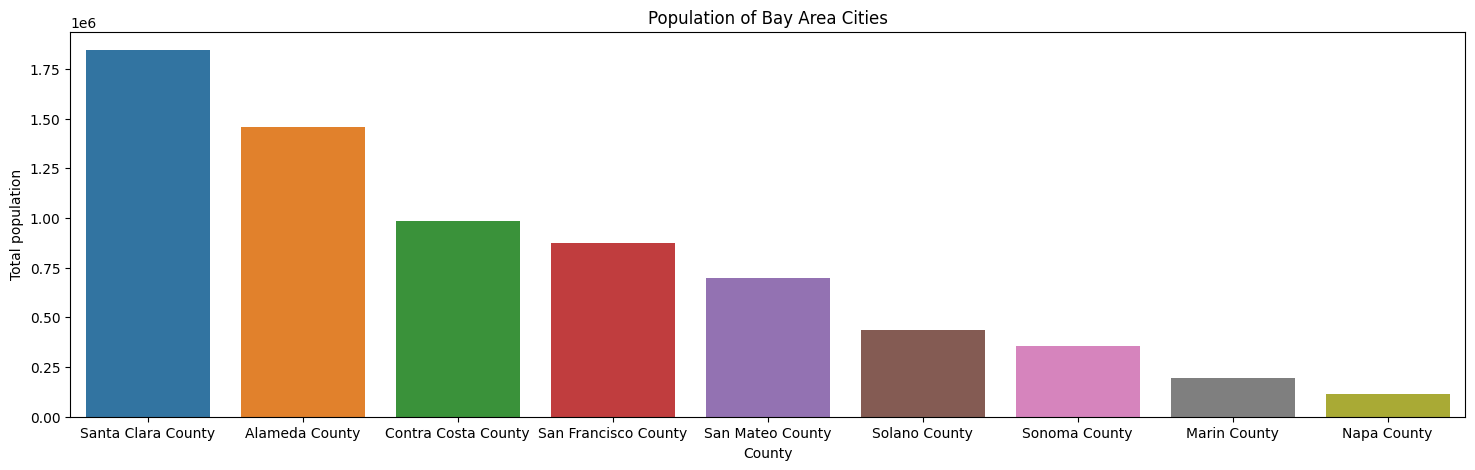

In [29]:
plt.figure(figsize=(18, 5))
sns.barplot(y='Total population', x='County', data=demographics.groupby(by='County')['Total population'].sum().to_frame().reset_index().sort_values(by='Total population', ascending=False), estimator=sum, errorbar=None).set(title='Population of Bay Area Cities')

pd.options.display.float_format = '{:,.0f}'.format

df_2 = demographics.groupby(by='County')['Total population'].sum().to_frame().sort_values(by='Total population', ascending=False)
df_2['Total population'] = df_2['Total population'].astype('float')
df_2.transpose()

[Text(0.5, 1.0, 'Population of Santa Clara County Cities')]

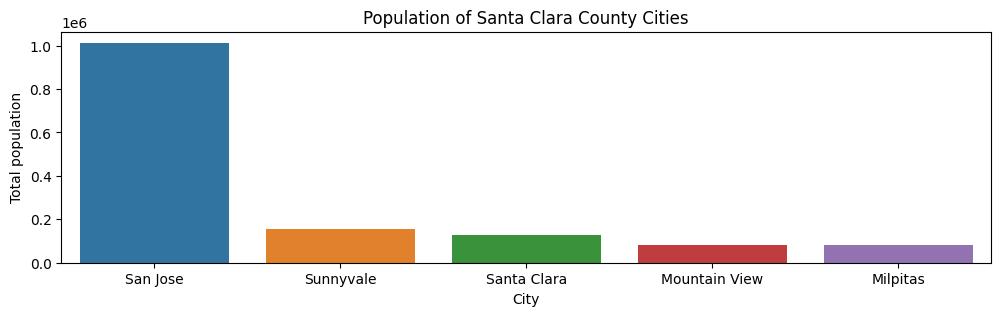

In [30]:
# show the top 5 cities and their populations for top 3 counties
top_cities_santa = demographics[demographics['County'] == 'Santa Clara County'].sort_values(by='Total population', ascending=False)
top_cities_santa['Total population'] = top_cities_santa['Total population'].astype('float')

plt.figure(figsize=(12, 3))
sns.barplot(y='Total population', x='City', data=top_cities_santa.head(5)).set(title='Population of Santa Clara County Cities')

[Text(0.5, 1.0, 'Population of Alameda County Cities')]

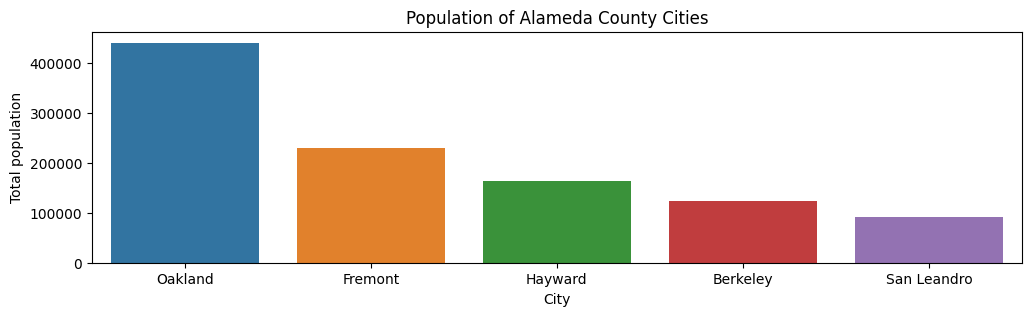

In [31]:
# show the top 5 cities and their populations for top 3 counties
top_cities_alameda = demographics[demographics['County'] == 'Alameda County'].sort_values(by='Total population', ascending=False)
top_cities_alameda['Total population'] = top_cities_alameda['Total population'].astype('float')

plt.figure(figsize=(12, 3))
sns.barplot(y='Total population', x='City', data=top_cities_alameda.head(5)).set(title='Population of Alameda County Cities')

,0,1,2,3,4,5,6,7,8
County,Contra Costa County,San Mateo County,Santa Clara County,Alameda County,Marin County,Sonoma County,Solano County,Napa County,San Francisco County
count_cities,19,19,15,13,11,9,7,5,1


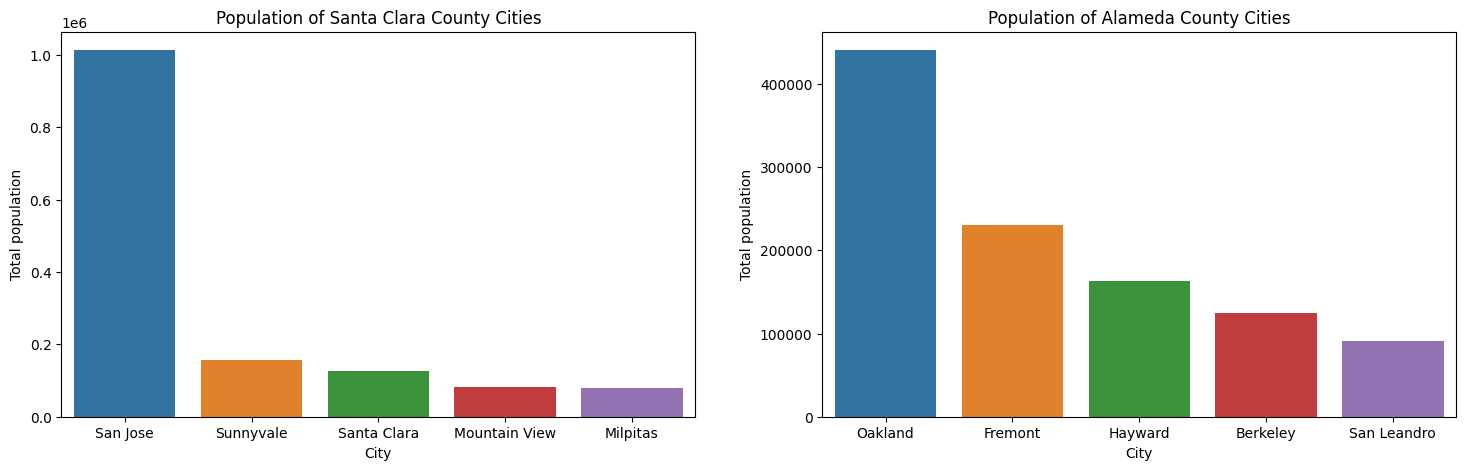

In [82]:
fig = plt.figure(figsize=[18,5])

plt.subplot(1,2,1)
ax = sns.barplot(y='Total population', x='City', data=top_cities_santa.head(5)).set(title='Population of Santa Clara County Cities')

plt.subplot(1,2,2)
ax = sns.barplot(y='Total population', x='City', data=top_cities_alameda.head(5)).set(title='Population of Alameda County Cities')
# ax.set_title('Property Crime Prediction vs Actuals', fontsize=12)

demographics.groupby(by='County')['City'].count().to_frame().reset_index().sort_values(by='City', ascending=False).reset_index().iloc[:,1:].rename(columns={'City': 'count_cities'}).transpose()

In [80]:
# demographics.groupby(by='County')['City'].count().to_frame().reset_index().sort_values(by='City', ascending=False).reset_index().iloc[:,1:].rename(columns={'City': 'count_cities'}).transpose()

[Text(0.5, 1.0, 'Population of Contra Costa County Cities')]

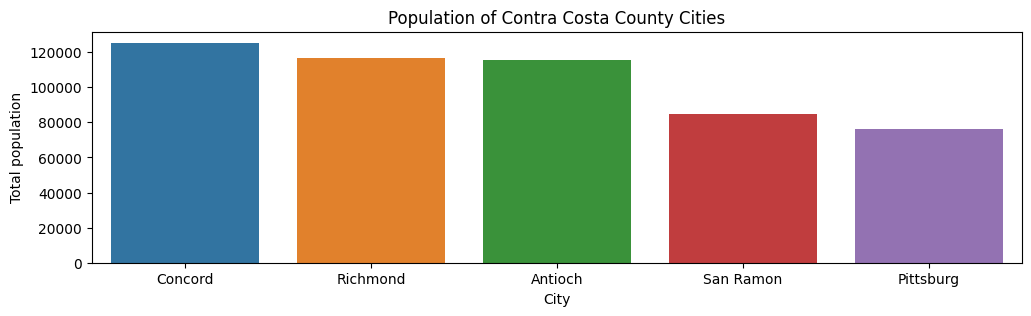

In [32]:
# show the top 5 cities and their populations for top 3 counties
top_cities_contra = demographics[demographics['County'] == 'Contra Costa County'].sort_values(by='Total population', ascending=False)
top_cities_contra['Total population'] = top_cities_contra['Total population'].astype('float')

plt.figure(figsize=(12, 3))
sns.barplot(y='Total population', x='City', data=top_cities_contra.head(5)).set(title='Population of Contra Costa County Cities')

Santa Clara County is the largest in the Bay Area with almost 2 million residents spread across 15 municipalities. The majority of its residents reside in San Jose, which has >1M total residents.

Alameda County residents largely live in Oakland, while Contra Costa County residents are a bit more evenly dispersed among its top 5 towns.

San Francisco is the 4th largest county with almost 900K residents, though the county is comprised solely of the City of San Francisco, packed on to less than 50 square miles.

## Education Data

In [34]:
education.columns

Index(['Column1', 'City', '18 -24 Total Population',
       '18-24 Less than high school graduate',
       '18-24 High school graduate (includes equivalency)',
       '18-24 Some college or associate's degree',
       '18-24 Bachelor's degree or higher', '25+ Total Population',
       '25+ Less than 9th grade', '25+ 9th to 12th grade, no diploma',
       '25+ High school graduate (includes equivalency)',
       '25+ Some college, no degree', '25+ Associate's degree',
       '25+ Bachelor's degree', '25+ Graduate or professional degree',
       '25+ High school graduate or higher', '25+ Bachelor's degree or higher',
       '25-34 Total Population', '25-34 High school graduate or higher',
       '25-34 Bachelor's degree or higher', '35-44 Total Population',
       '35-44 High school graduate or higher',
       '35-44 Bachelor's degree or higher', '45-64 Total Population',
       '45-64 High school graduate or higher',
       '45-64 Bachelor's degree or higher', '65+ Total Population',
  

In [90]:
education["25+ Bachelor's Percentage"] = (education["25+ Bachelor's degree"] / education["25+ Total Population"])*100
education["Graduate Percentage"] = (education["25+ Graduate or professional degree"] / education["25+ Total Population"])*100
education["25+ Less HS Percentage"] = ((education["25+ 9th to 12th grade, no diploma"] + education['25+ Less than 9th grade']) / education['25+ Total Population'])*100

education["25+ HS or Less Percentage"] = ((education["25+ 9th to 12th grade, no diploma"] + education['25+ Less than 9th grade'] + education['25+ High school graduate (includes equivalency)']) / education['25+ Total Population'])*100

education["18_24 Less HS"] = (education["18-24 Less than high school graduate"] / education["18 -24 Total Population"])*100
education["18_24 HS Grad"] = (education["18-24 High school graduate (includes equivalency)"] / education["18 -24 Total Population"])*100
education["18_24 Some College"] = (education["18-24 Some college or associate's degree"] / education["18 -24 Total Population"])*100
education["18_24 Bachelor+"] = (education["18-24 Bachelor's degree or higher"] / education["18 -24 Total Population"])*100


education.head()

,Column1,City,18 -24 Total Population,18-24 Less than high school graduate,18-24 High school graduate (includes equivalency),18-24 Some college or associate's degree,18-24 Bachelor's degree or higher,25+ Total Population,25+ Less than 9th grade,"25+ 9th to 12th grade, no diploma",25+ High school graduate (includes equivalency),"25+ Some college, no degree",25+ Associate's degree,25+ Bachelor's degree,25+ Graduate or professional degree,25+ High school graduate or higher,25+ Bachelor's degree or higher,25-34 Total Population,25-34 High school graduate or higher,25-34 Bachelor's degree or higher,35-44 Total Population,35-44 High school graduate or higher,35-44 Bachelor's degree or higher,45-64 Total Population,45-64 High school graduate or higher,45-64 Bachelor's degree or higher,65+ Total Population,65+ High school graduate or higher,65+ Bachelor's degree or higher,County,25+ Bachelor's Percentage,Graduate Percentage,25+ Less HS Percentage,18_24 Less HS,18_24 HS Grad,18_24 Some College,18_24 Bachelor+,25+ HS or Less Percentage
0,0,Alameda,3644,142,1754,1219,529,56820,1017,2134,6833,8758,3572,21549,12957,53669,34506,11547,11402,7892,12848,12454,8395,20195,19049,11800,12230,10764,6419,Alameda County,37.93,22.80,5.55,3.90,48.13,33.45,14.52,17.57
1,1,Berkeley,27072,597,7302,13263,5910,75318,1628,727,5372,9259,2835,24348,31149,72963,55497,21086,20709,17270,12683,12601,9555,23852,22520,16559,17697,17133,12113,Alameda County,32.33,41.36,3.13,2.21,26.97,48.99,21.83,10.26
2,2,Dublin,3276,47,1571,800,858,49204,1404,440,5109,5395,3614,18266,14976,47360,33242,9412,9126,6778,15913,15695,12199,16451,16280,11720,7428,6259,2545,Alameda County,37.12,30.44,3.75,1.43,47.95,24.42,26.19,14.13
3,3,Fremont,12766,823,3052,6375,2516,161130,4825,5271,23794,16229,8423,49371,53217,151034,102588,33362,32896,24130,41953,40750,31510,55643,52258,34353,30172,25130,12595,Alameda County,30.64,33.03,6.27,6.45,23.91,49.94,19.71,21.03
4,4,Hayward,11537,1622,4191,4958,766,114163,13795,7728,29291,19008,7825,25714,10802,92640,36516,27610,25871,12408,23371,19752,7857,40435,30236,11539,22747,16781,4712,Alameda County,22.52,9.46,18.85,14.06,36.33,42.97,6.64,44.51


[Text(0.5, 1.0, 'Percentage of 25+ Population with a Graduate Degree\n(Weighted Average Across Cities)')]

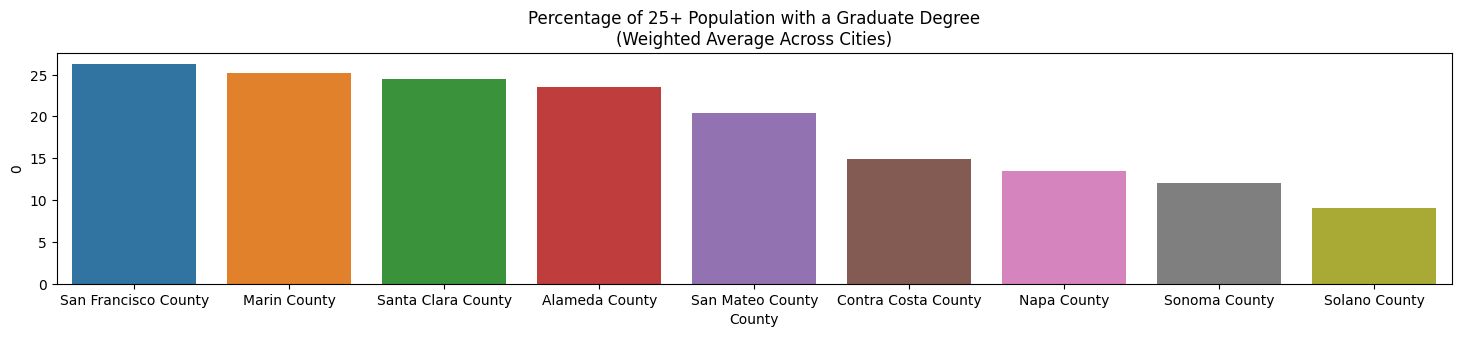

In [91]:
# weighted average percentage of the 25+ aged population with graduate or professional degree
edu_mid = education.groupby(by='County').apply(lambda x: np.average(x["25+ Bachelor's Percentage"],weights=x['25+ Total Population'])).sort_values(ascending=False).to_frame().reset_index()
edu_high = education.groupby(by='County').apply(lambda x: np.average(x["Graduate Percentage"],weights=x['25+ Total Population'])).sort_values(ascending=False).to_frame().reset_index()
edu_low = education.groupby(by='County').apply(lambda x: np.average(x["25+ Less HS Percentage"],weights=x['25+ Total Population'])).sort_values(ascending=False).to_frame().reset_index()

edu_HS = education.groupby(by='County').apply(lambda x: np.average(x["25+ HS or Less Percentage"],weights=x['25+ Total Population'])).sort_values(ascending=False).to_frame().reset_index()

plt.figure(figsize=(18, 3))
sns.barplot(y=0, x='County', data=edu_high).set(title="Percentage of 25+ Population with a Graduate Degree\n(Weighted Average Across Cities)")


# edu_high


In [155]:
edu_high = edu_high.rename(columns={0: 'Percent'})
edu_low = edu_low.rename(columns={0: 'Percent'})
edu_mid = edu_mid.rename(columns={0: 'Percent'})

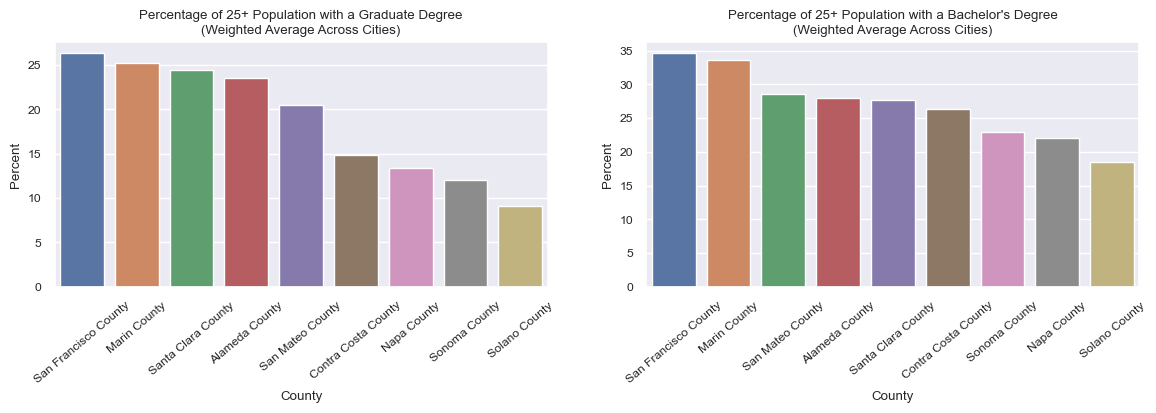

In [239]:
sns.set(font_scale=0.8)

fig = plt.figure(figsize=[14,7]).tight_layout()

plt.subplot(2,2,1)
ax = sns.barplot(y='Percent', x='County', data=edu_high)
ax.set(title="Percentage of 25+ Population with a Graduate Degree\n(Weighted Average Across Cities)")
for item in ax.get_xticklabels():
    item.set_rotation(40)

plt.subplot(2,2,2)
ax = sns.barplot(y='Percent', x='County', data=edu_mid)
ax.set(title="Percentage of 25+ Population with a Bachelor's Degree\n(Weighted Average Across Cities)")
for item in ax.get_xticklabels():
    item.set_rotation(40)
    
# plt.subplot(2,2,3)
# ax = sns.barplot(y='Percent', x='County', data=edu_low)
# ax.set(title="Percentage of 25+ Population with a High School Diploma or Lower\n(Weighted Average Across Cities)")
# for item in ax.get_xticklabels():
#     item.set_rotation(24)

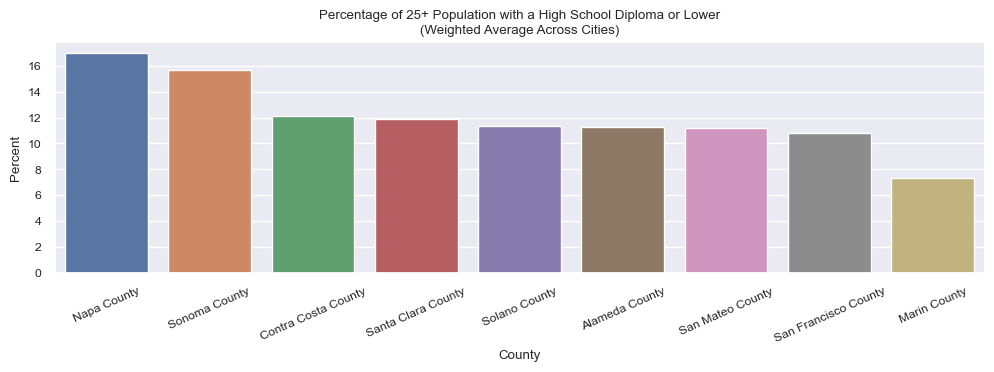

In [229]:
fig = plt.figure(figsize=[12,3]).tight_layout()

ax = sns.barplot(y='Percent', x='County', data=edu_low)
ax.set(title="Percentage of 25+ Population with a High School Diploma or Lower\n(Weighted Average Across Cities)")
for item in ax.get_xticklabels():
    item.set_rotation(24)

[Text(0.5, 1.0, "Percentage of 25+ Population with a Bachelor's Degree\n(Weighted Average Across Cities)")]

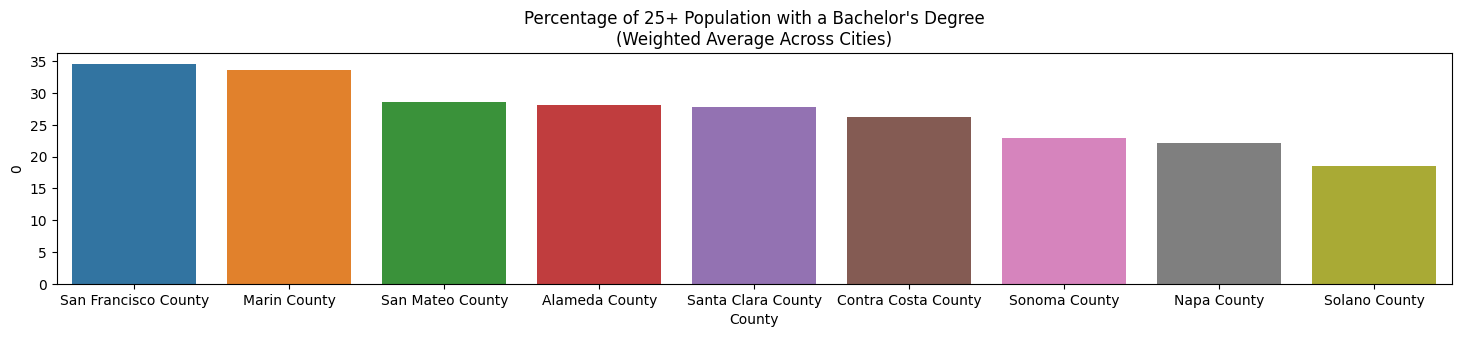

In [88]:
plt.figure(figsize=(18, 3))
sns.barplot(y=0, x='County', data=edu_mid).set(title="Percentage of 25+ Population with a Bachelor's Degree\n(Weighted Average Across Cities)")



[Text(0.5, 1.0, 'Percentage of 25+ Population with Less Than a High School Diploma\n(Weighted Average Across Cities)')]

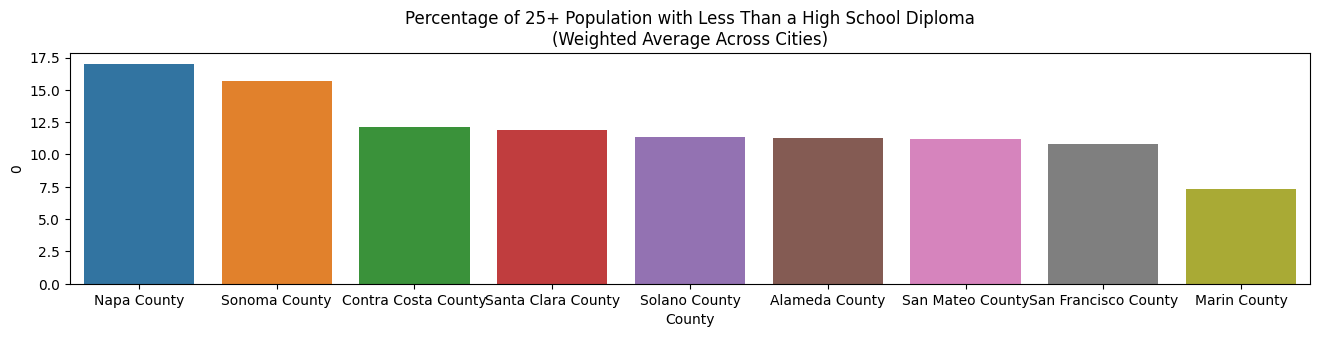

In [38]:
plt.figure(figsize=(16, 3))
sns.barplot(y=0, x='County', data=edu_low).set(title="Percentage of 25+ Population with Less Than a High School Diploma\n(Weighted Average Across Cities)")



[Text(0.5, 1.0, 'Percentage of 25+ Population with a High School Diploma or Less\n(Weighted Average Across Cities)')]

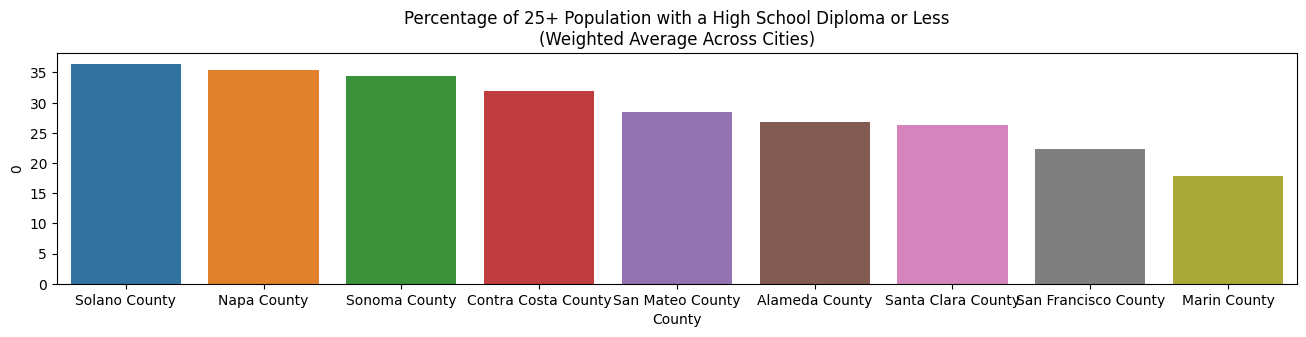

In [92]:
plt.figure(figsize=(16, 3))
sns.barplot(y=0, x='County', data=edu_HS).set(title="Percentage of 25+ Population with a High School Diploma or Less\n(Weighted Average Across Cities)")



In [110]:
# print(edu_HS)
# print(edu_high)
# print(edu_mid)

education[['City', 'County', "25+ Bachelor's Percentage", '25+ Total Population']].sort_values(by="25+ Bachelor's Percentage", ascending=False).head(10).reset_index().drop(columns=['index'])



,City,County,25+ Bachelor's Percentage,25+ Total Population
0,San Anselmo,Marin County,43.01,8945
1,Ross,Marin County,42.71,1625
2,Belvedere,Marin County,42.12,1643
3,Walnut Creek,Contra Costa County,41.02,51851
4,San Ramon,Contra Costa County,40.49,56663
5,Tiburon,Marin County,39.99,6720
6,Mill Valley,Marin County,39.35,10520
7,Larkspur,Marin County,38.37,10010
8,Corte Madera,Marin County,38.13,6735
9,Alameda,Alameda County,37.93,56820


In [112]:
education[['City', 'County', "Graduate Percentage", '25+ Total Population']].sort_values(by="Graduate Percentage", ascending=False).head(10).reset_index().drop(columns=['index'])



,City,County,Graduate Percentage,25+ Total Population
0,Mountain View,Santa Clara County,45.43,59044
1,Berkeley,Alameda County,41.36,75318
2,Ross,Marin County,41.23,1625
3,Belvedere,Marin County,40.72,1643
4,Sunnyvale,Santa Clara County,37.61,112990
5,Tiburon,Marin County,37.59,6720
6,Mill Valley,Marin County,36.06,10520
7,Corte Madera,Marin County,35.96,6735
8,Sausalito,Marin County,35.41,6434
9,Santa Clara,Santa Clara County,34.96,90840


In [111]:
education[['City', 'County', "25+ HS or Less Percentage", '25+ Total Population']].sort_values(by="25+ HS or Less Percentage", ascending=False).head(10).reset_index().drop(columns=['index'])



,City,County,25+ HS or Less Percentage,25+ Total Population
0,Pittsburg,Contra Costa County,49.22,51908
1,Hayward,Alameda County,44.51,114163
2,San Leandro,Alameda County,39.89,67147
3,Antioch,Contra Costa County,38.95,76519
4,Richmond,Contra Costa County,37.90,81025
5,Vallejo,Solano County,37.78,88669
6,Fairfield,Solano County,37.37,77589
7,Napa,Napa County,35.40,55826
8,Daly City,San Mateo County,35.17,77014
9,Santa Rosa,Sonoma County,34.34,125328


# Economic Data

## Key Questions:
* Which counties have the highest/lowest median household income? Which cities comprise the top 5 across all counties?
* Which counties/cities have the greatest percentage of households making > 200K?  What about less than 35K?
* Which counties/cities have the highest unemployment rates? The lowest?

In [39]:
economic.columns

# economic.drop(columns=['More than $200k'], inplace=True)

Index(['City', 'Population 16 years and over', 'In labor force',
       'Civilian labor force', 'Employed', 'Unemployed', 'Armed Forces',
       'Not in labor force', 'Workers 16 years and over',
       'Car, truck, or van -- drove alone', 'Car, truck, or van -- carpooled',
       'Public transportation (excluding taxicab)', 'Walked', 'Other means',
       'Worked from home', 'Mean travel time to work (minutes)',
       'Civilian employed population 16 years and over',
       'Agriculture, forestry, fishing and hunting, and mining',
       'Construction', 'Manufacturing', 'Wholesale trade', 'Retail trade',
       'Transportation and warehousing, and utilities', 'Information',
       'Finance and insurance, and real estate and rental and leasing',
       'Professional, scientific, and management, and administrative and waste management services',
       'Educational services, and health care and social assistance',
       'Arts, entertainment, and recreation, and accommodation and food 

In [40]:
pd.options.display.float_format = '{:,.2f}'.format

economic['Unemployment_rate'] = ((economic['Unemployed']/economic['In labor force'])*100)
economic['Less than $35k'] = ((economic['Less than $10,000'] + economic['$10,000 to $14,999'] + economic['$15,000 to $24,999'] + economic['$25,000 to $34,999'])/economic['Total households'])*100
economic['More than $150k'] = ((economic['$200,000 or more'] + economic['$150,000 to $199,999'])/economic['Total households'])*100


# economic


,City,Population 16 years and over,In labor force,Civilian labor force,Employed,Unemployed,Armed Forces,Not in labor force,Workers 16 years and over,"Car, truck, or van -- drove alone","Car, truck, or van -- carpooled",Public transportation (excluding taxicab),Walked,Other means,Worked from home,Mean travel time to work (minutes),Civilian employed population 16 years and over,"Agriculture, forestry, fishing and hunting, and mining",Construction,Manufacturing,Wholesale trade,Retail trade,"Transportation and warehousing, and utilities",Information,"Finance and insurance, and real estate and rental and leasing","Professional, scientific, and management, and administrative and waste management services","Educational services, and health care and social assistance","Arts, entertainment, and recreation, and accommodation and food services","Other services, except public administration",Public administration,Total households,"Less than $10,000","$10,000 to $14,999","$15,000 to $24,999","$25,000 to $34,999","$35,000 to $49,999","$50,000 to $74,999","$75,000 to $99,999","$100,000 to $149,999","$150,000 to $199,999","$200,000 or more",Median household income (dollars),Mean household income (dollars),With earnings,Mean earnings (dollars),With Social Security,Mean Social Security income (dollars),With retirement income,Mean retirement income (dollars),With Supplemental Security Income,Mean Supplemental Security Income (dollars),With cash public assistance income,Mean cash public assistance income (dollars),With Food Stamp/SNAP benefits in the past 12 months,County,Unemployment_rate,Less than $35k,More than $150k
0,Alameda,62106,41918,41322,38620,2702,596,20188,38053,18599,2166,2115,657,1061,13455,27.80,38620,251,1295,4227,525,2944,2223,1127,3107,6859,10237,2815,1221,1789,30281,958,486,1454,1494,2297,3557,3550,4316,3807,8362,115468,155556,24418,155725,7906,25021,6532,43954,1081,13996,1393,"7,085",2704,Alameda County,6.45,14.50,40.19
1,Berkeley,104883,65513,65513,59365,6148,0,39370,57877,17002,1654,2740,6073,3509,26899,24.10,59365,234,1760,2600,440,3884,1964,2743,3483,12413,21227,4631,2281,1705,43893,3166,1049,2197,2738,4059,4250,4298,6383,3951,11802,101048,152028,34185,154264,10422,24837,9622,44152,1208,8779,1126,"8,364",3639,Alameda County,9.38,20.85,35.89
2,Dublin,54715,38572,38524,37116,1408,48,16143,36915,14913,1522,571,639,675,18595,33.00,37116,0,798,4188,311,3718,1359,1577,2434,10837,7803,1916,860,1315,23688,481,303,211,607,645,1356,1731,2815,3243,12296,205219,221110,21819,221176,3776,21211,4205,41305,666,12367,1037,"7,376",1589,Alameda County,3.65,6.76,65.60
3,Fremont,180103,120383,120252,114961,5291,131,59720,112508,48581,4424,1893,766,1779,55065,27.60,114961,144,3258,17252,1587,7533,4283,5068,6857,36480,20701,4773,2828,4197,75716,2197,1599,2247,1996,2421,6427,6065,12994,11149,28621,155968,189180,65153,196351,17942,21598,14067,35062,3096,9197,4552,"5,013",3954,Alameda County,4.40,10.62,52.53
4,Hayward,129071,85086,84810,78612,6198,276,43985,75905,49264,7288,2178,864,708,15603,31.30,78612,192,6227,7974,1110,7959,8053,2285,3314,12424,18380,5913,2699,2082,48619,2761,1156,2511,2696,3157,6455,6425,9908,5276,8274,96386,120442,39960,121855,13711,19392,10686,26595,2747,10029,4378,"6,088",5308,Alameda County,7.28,18.77,27.87
5,Livermore,70155,48174,48174,44786,3388,0,21981,43379,23699,5097,560,361,1547,12115,28.40,44786,336,3727,4102,1154,3797,1516,960,2874,9915,9019,3576,1709,2101,31472,1038,581,1587,1241,1321,2908,3374,5633,4576,9213,130111,161055,25909,156018,8120,21462,8725,43923,942,11622,1204,"6,955",2063,Alameda County,7.03,14.13,43.81
6,Oakland,359568,241135,240797,222304,18493,338,118433,218313,102481,13813,14616,8068,6598,72737,28.30,222304,994,13611,15954,3276,20341,12723,9406,13323,43409,47554,18430,14672,8611,170366,10016,8615,10978,10300,15185,23499,17313,25385,18100,30975,82236,122444,135704,127200,38798,20432,30984,33733,11590,10034,11385,"6,269",26001,Alameda County,7.67,23.43,28.81
7,Pleasanton,64676,42391,42122,39486,2636

,0,1,2,3,4,5,6,7,8
County,Santa Clara County,Marin County,San Mateo County,San Francisco County,Alameda County,Contra Costa County,Napa County,Solano County,Sonoma County
median_household_income,"139,932","127,045","123,182","121,826","112,021","104,026","92,878","87,722","86,459"


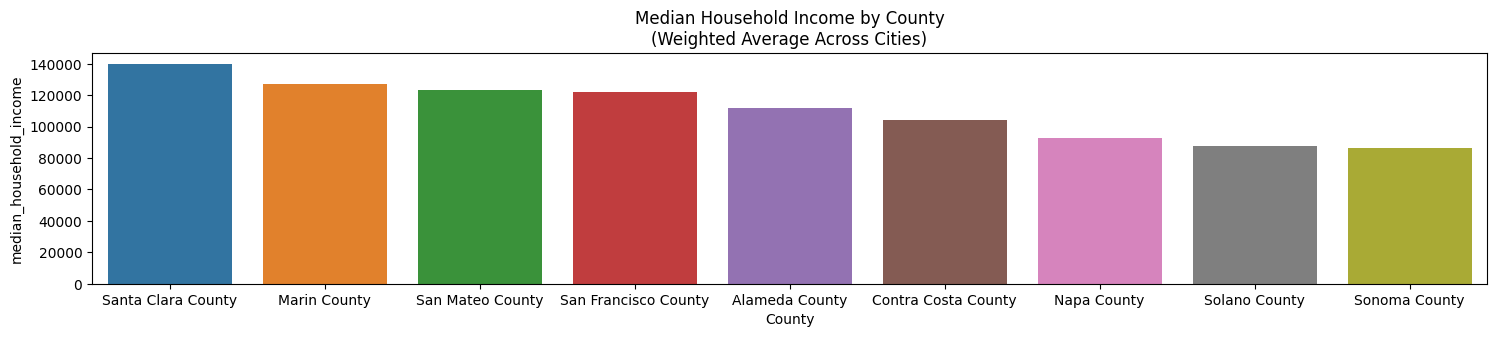

In [133]:
econ_median = economic.groupby(by='County').apply(lambda x: np.average(x["Median household income (dollars)"],weights=x['Total households'])).rename('median_household_income').sort_values(ascending=False).to_frame().reset_index()
# econ_median

plt.figure(figsize=(18, 3))
sns.barplot(y='median_household_income', x='County', data=econ_median).set(title="Median Household Income by County\n(Weighted Average Across Cities)")
econ_median.transpose()

,0,1,2,3,4,5
City,Palo Alto,Milpitas,Mountain View,Sunnyvale,Santa Clara,San Jose
Median household income (dollars),"195,781","169,460","157,243","156,059","155,238","126,377"


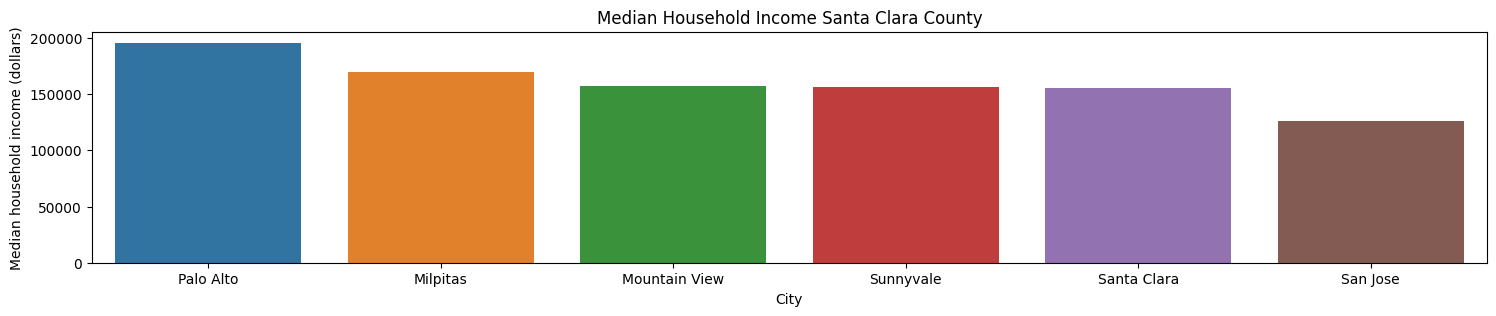

In [139]:
plt.figure(figsize=(18, 3))
sns.barplot(y='Median household income (dollars)', x='City', data=economic[economic['County'] == 'Santa Clara County'].sort_values(by='Median household income (dollars)', ascending=False)).set(title="Median Household Income Santa Clara County")

pd.options.display.float_format = '{:,.0f}'.format

temp = economic[economic['County'] == 'Santa Clara County'][['City', 'Median household income (dollars)']].sort_values(by='Median household income (dollars)', ascending=False).reset_index().drop(columns=['index'])
temp['Median household income (dollars)'] = temp['Median household income (dollars)'].astype('float')
temp.transpose()


In [134]:
# pd.options.display.float_format = '{:,.0f}'.format

# temp = economic[economic['County'] == 'Santa Clara County'][['City', 'Median household income (dollars)']].sort_values(by='Median household income (dollars)', ascending=False).reset_index().drop(columns=['index'])
# temp['Median household income (dollars)'] = temp['Median household income (dollars)'].astype('float')
# temp.transpose()

[Text(0.5, 1.0, 'Percentage of Households Making >$150K\n(Weighted Average Across Cities)')]

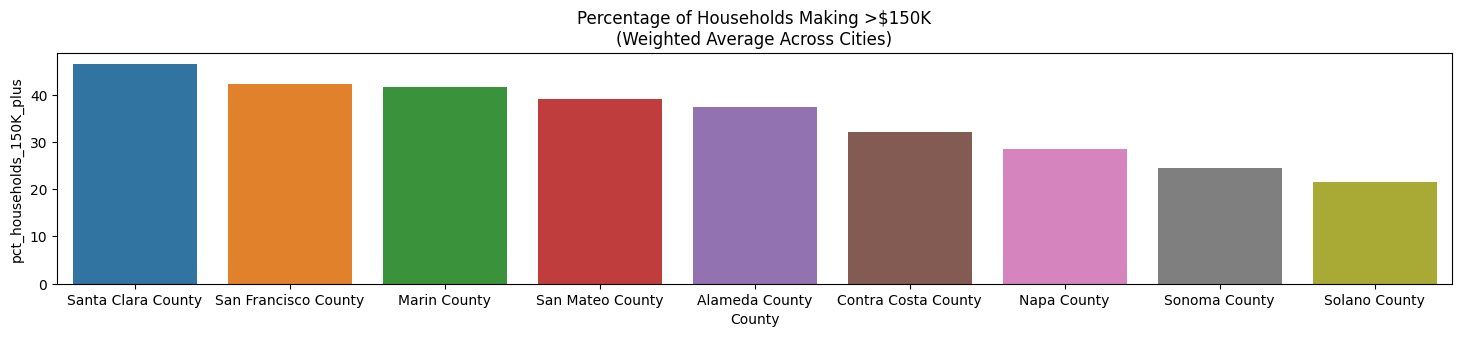

In [135]:
econ_high = economic.groupby(by='County').apply(lambda x: np.average(x["More than $150k"],weights=x['Total households'])).rename('pct_households_150K_plus').sort_values(ascending=False).to_frame().reset_index()
# econ_high

plt.figure(figsize=(18, 3))
sns.barplot(y='pct_households_150K_plus', x='County', data=econ_high).set(title="Percentage of Households Making >$150K\n(Weighted Average Across Cities)")


,0,1,2,3,4,5,6,7,8
County,San Francisco County,Sonoma County,Solano County,Alameda County,Napa County,Contra Costa County,Marin County,San Mateo County,Santa Clara County
pct_households_below_35K,20,18,18,18,18,17,14,13,12


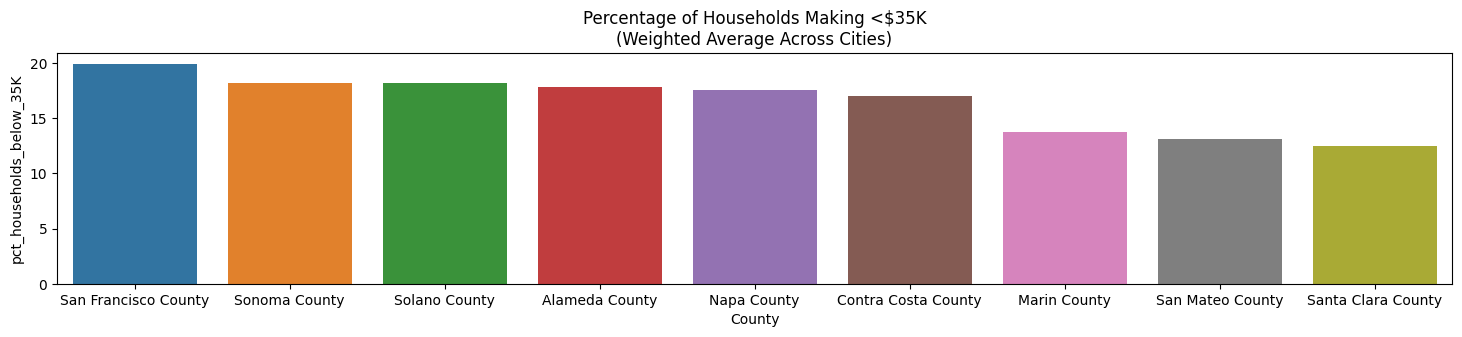

In [142]:
econ_low = economic.groupby(by='County').apply(lambda x: np.average(x["Less than $35k"],weights=x['Total households'])).rename('pct_households_below_35K').sort_values(ascending=False).to_frame().reset_index()
#econ_low

plt.figure(figsize=(18, 3))
sns.barplot(y='pct_households_below_35K', x='County', data=econ_low).set(title="Percentage of Households Making <$35K\n(Weighted Average Across Cities)")

econ_low.transpose()



In [145]:
economic[['City', 'County', 'Median household income (dollars)']].sort_values(by='Median household income (dollars)', ascending=False).sort_values(by='Median household income (dollars)', ascending=False).reset_index().drop(columns=['index']).head(10)



,City,County,Median household income (dollars)
0,Dublin,Alameda County,205219
1,Palo Alto,Santa Clara County,195781
2,Tiburon,Marin County,192292
3,Corte Madera,Marin County,183661
4,Mill Valley,Marin County,179529
5,Milpitas,Santa Clara County,169460
6,San Ramon,Contra Costa County,162388
7,Mountain View,Santa Clara County,157243
8,Sunnyvale,Santa Clara County,156059
9,Fremont,Alameda County,155968


[Text(0.5, 1.0, 'Average Unemployment Rate by County\n(Weighted Average Across Cities)')]

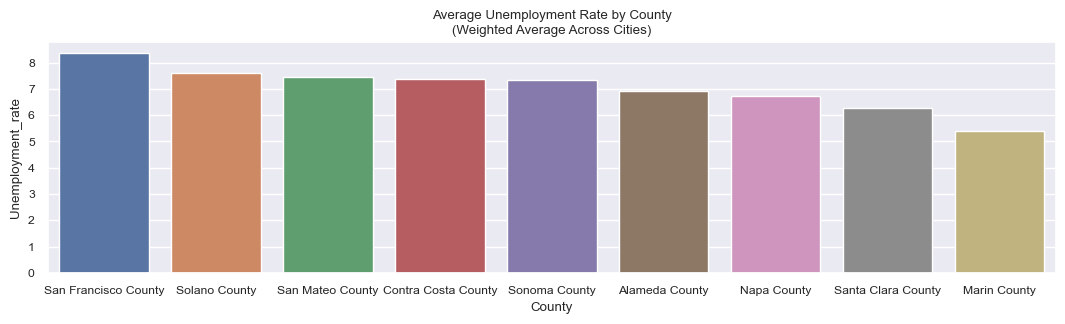

In [300]:
econ_unemploy = economic.groupby(by='County').apply(lambda x: np.average(x["Unemployment_rate"],weights=x['Population 16 years and over'])).rename('Unemployment_rate').sort_values(ascending=False).to_frame().reset_index()
# econ_unemploy

plt.figure(figsize=(13, 3))
sns.barplot(y='Unemployment_rate', x='County', data=econ_unemploy).set(title="Average Unemployment Rate by County\n(Weighted Average Across Cities)")

In [310]:
# economic

top_10 = economic[['City', 'County', 'Unemployment_rate']].sort_values(by='Unemployment_rate', ascending=False).head(5)

bottom_10 = economic[['City', 'County', 'Unemployment_rate']].sort_values(by='Unemployment_rate').head(5)
bottom_10 = bottom_10.sort_values(by='Unemployment_rate', ascending=False)

In [318]:
unemployment_consol = pd.concat([top_10, bottom_10]).reset_index().drop(columns=['index'])
unemployment_consol.transpose()

,0,1,2,3,4,5,6,7,8,9
City,Fairfax,Pittsburg,Vallejo,Richmond,Berkeley,Dublin,Mill Valley,Mountain View,Walnut Creek,Larkspur
County,Marin County,Contra Costa County,Solano County,Contra Costa County,Alameda County,Alameda County,Marin County,Santa Clara County,Contra Costa County,Marin County
Unemployment_rate,12,11,10,9,9,4,4,3,3,2


,0,1,2,3,4,5,6,7,8,9
City,Fairfax,Pittsburg,Vallejo,Richmond,Berkeley,Dublin,Mill Valley,Mountain View,Walnut Creek,Larkspur
County,Marin County,Contra Costa County,Solano County,Contra Costa County,Alameda County,Alameda County,Marin County,Santa Clara County,Contra Costa County,Marin County
Unemployment_rate,12,11,10,9,9,4,4,3,3,2


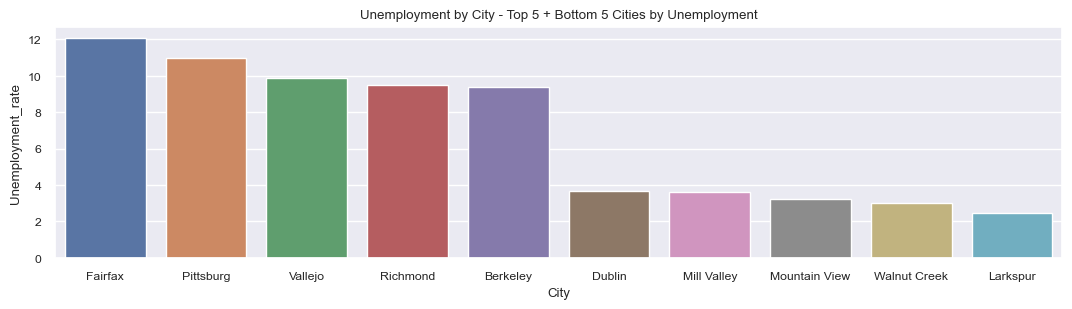

In [316]:
plt.figure(figsize=(13, 3))
sns.barplot(y='Unemployment_rate', x='City', data=unemployment_consol).set(title="Unemployment by City - Top 5 + Bottom 5 Cities by Unemployment")
# unemployment_consol.transpose()



# Crime

* Which counties have the highest crime rates per capita?
* What about the lowest?
* Which cities drive the high crime counties?
* Crime trends over the past 5 years?

In [46]:
df_crime.head()
# df_crime['County'].unique()

,Year,County,NCICCode,Month,Violent_sum,Homicide_sum,ForRape_sum,Robbery_sum,AggAssault_sum,Property_sum,Burglary_sum,VehicleTheft_sum,LTtotal_sum
1,1985,Alameda County,Alameda Co. Sheriff's Department,2,33,0,2,9,22,288,105,35,148
2,1985,Alameda County,Alameda Co. Sheriff's Department,3,53,1,2,22,28,362,154,32,176
3,1985,Alameda County,Alameda Co. Sheriff's Department,4,42,1,2,13,26,348,123,44,181
4,1985,Alameda County,Alameda Co. Sheriff's Department,5,22,0,3,6,13,333,111,41,181
5,1985,Alameda County,Alameda Co. Sheriff's Department,6,39,1,5,12,21,338,107,28,203


In [241]:
crime = df_crime[(df_crime['Year'] == 2017) | (df_crime['Year'] == 2018) | (df_crime['Year'] == 2019) | (df_crime['Year'] == 2020) | (df_crime['Year'] == 2021)]
crime.rename(columns={'NCICCode': 'City'}, inplace=True)
crime.head()

/var/folders/2m/zlypmb_13gv_6p1wh0w96gvw0000gn/T/ipykernel_57371/2776557005.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime.rename(columns={'NCICCode': 'City'}, inplace=True)


,Year,County,City,Month,Violent_sum,Homicide_sum,ForRape_sum,Robbery_sum,AggAssault_sum,Property_sum,Burglary_sum,VehicleTheft_sum,LTtotal_sum
9125,2017,Alameda County,Alameda Co. Sheriff's Department,1,47,1,1,16,29,191,36,73,82
9126,2017,Alameda County,Alameda Co. Sheriff's Department,2,37,0,3,14,20,178,33,66,79
9128,2017,Alameda County,Alameda Co. Sheriff's Department,4,53,0,3,13,37,185,35,47,103
9129,2017,Alameda County,Alameda Co. Sheriff's Department,5,44,0,1,13,30,177,34,55,88
9130,2017,Alameda County,Alameda Co. Sheriff's Department,6,69,0,3,20,46,170,26,44,100


In [242]:
crime = pd.merge(crime, demographics[['City', 'Total population']], on='City', how='left')
crime = crime.dropna()
crime['violent_100K'] = (crime['Violent_sum'] / crime['Total population']) * 100000
crime['property_100K'] = (crime['Property_sum'] / crime['Total population']) * 100000

crime['homicide_100K'] = (crime['Homicide_sum'] / crime['Total population']) * 100000
crime['rape_100K'] = (crime['ForRape_sum'] / crime['Total population']) * 100000
crime['robbery_100K'] = (crime['Robbery_sum'] / crime['Total population']) * 100000
crime['assault_100K'] = (crime['AggAssault_sum'] / crime['Total population']) * 100000
crime['burglary_100K'] = (crime['Burglary_sum'] / crime['Total population']) * 100000
crime['veh_100K'] = (crime['VehicleTheft_sum'] / crime['Total population']) * 100000
crime['LT_100K'] = (crime['LTtotal_sum'] / crime['Total population']) * 100000

crime.head()

# 71 unique cities

,Year,County,City,Month,Violent_sum,Homicide_sum,ForRape_sum,Robbery_sum,AggAssault_sum,Property_sum,Burglary_sum,VehicleTheft_sum,LTtotal_sum,Total population,violent_100K,property_100K,homicide_100K,rape_100K,robbery_100K,assault_100K,burglary_100K,veh_100K,LT_100K
9,2017,Alameda County,Alameda,1,13,0,2,8,3,198,14,37,147,"78,280",17,253,0,3,10,4,18,47,188
10,2017,Alameda County,Alameda,2,21,0,3,10,8,135,17,33,85,"78,280",27,172,0,4,13,10,22,42,109
11,2017,Alameda County,Alameda,4,25,0,2,16,7,148,21,32,95,"78,280",32,189,0,3,20,9,27,41,121
12,2017,Alameda County,Alameda,5,14,0,1,10,3,194,15,24,155,"78,280",18,248,0,1,13,4,19,31,198
13,2017,Alameda County,Alameda,6,18,0,1,9,8,196,13,26,157,"78,280",23,250,0,1,11,10,17,33,201


In [265]:
crime.to_csv("crime_output_csv.csv")

In [246]:
violent_crime_cty = crime.groupby(by='County').apply(lambda x: np.average(x["violent_100K"],weights=x['Total population'])).rename('wgt_avg_violent_crime_per_100k').sort_values(ascending=False).to_frame().reset_index()
violent_crime_cty


,County,wgt_avg_violent_crime_per_100k
0,Alameda County,54
1,San Francisco County,54
2,Solano County,45
3,Contra Costa County,42
4,Sonoma County,39
5,Marin County,31
6,Santa Clara County,30
7,Napa County,29
8,San Mateo County,21


In [254]:
violent_crime_cty = crime.groupby(by='County').apply(lambda x: np.average(x["homicide_100K"],weights=x['Total population'])).rename('wgt_avg_homicide_per_100k').sort_values(ascending=False).to_frame().reset_index()
violent_crime_cty


,County,wgt_avg_homicide_per_100k
0,Alameda County,1
1,Solano County,1
2,Contra Costa County,1
3,San Francisco County,0
4,Santa Clara County,0
5,Sonoma County,0
6,San Mateo County,0
7,Marin County,0
8,Napa County,0


In [252]:
violent_crime_cty = crime.groupby(by='County').apply(lambda x: np.average(x["assault_100K"],weights=x['Total population'])).rename('wgt_avg_assault_per_100k').sort_values(ascending=False).to_frame().reset_index()
violent_crime_cty


,County,wgt_avg_assault_per_100k
0,Sonoma County,27
1,Solano County,25
2,Contra Costa County,25
3,San Francisco County,23
4,Alameda County,23
5,Napa County,18
6,Marin County,17
7,Santa Clara County,16
8,San Mateo County,10


In [253]:
violent_crime_cty = crime.groupby(by='County').apply(lambda x: np.average(x["robbery_100K"],weights=x['Total population'])).rename('wgt_avg_robbery_per_100k').sort_values(ascending=False).to_frame().reset_index()
violent_crime_cty


,County,wgt_avg_robbery_per_100k
0,San Francisco County,27
1,Alameda County,26
2,Solano County,14
3,Contra Costa County,14
4,Marin County,10
5,Santa Clara County,9
6,San Mateo County,7
7,Sonoma County,6
8,Napa County,5


In [51]:
property_crime_cty = crime.groupby(by=['County']).apply(lambda x: np.average(x["property_100K"],weights=x['Total population'])).rename('wgt_avg_property_crime_per_100k').sort_values(ascending=False).to_frame().reset_index()
property_crime_cty


,County,wgt_avg_property_crime_per_100k
0,San Francisco County,449.65
1,Alameda County,325.30
2,Solano County,232.38
3,Contra Costa County,230.44
4,Marin County,214.07
5,Santa Clara County,202.30
6,San Mateo County,159.44
7,Sonoma County,136.82
8,Napa County,132.12


In [256]:
property_crime_cty = crime.groupby(by=['County']).apply(lambda x: np.average(x["burglary_100K"],weights=x['Total population'])).rename('wgt_avg_burglary_per_100k').sort_values(ascending=False).to_frame().reset_index()
property_crime_cty


,County,wgt_avg_burglary_per_100k
0,Solano County,64
1,San Francisco County,56
2,Alameda County,35
3,Santa Clara County,32
4,Marin County,30
5,Contra Costa County,30
6,Napa County,26
7,San Mateo County,25
8,Sonoma County,22


In [255]:
property_crime_cty = crime.groupby(by=['County']).apply(lambda x: np.average(x["veh_100K"],weights=x['Total population'])).rename('wgt_avg_vehicle_theft_per_100k').sort_values(ascending=False).to_frame().reset_index()
property_crime_cty


,County,wgt_avg_vehicle_theft_per_100k
0,Alameda County,69
1,Contra Costa County,50
2,San Francisco County,48
3,Santa Clara County,47
4,Solano County,43
5,Marin County,43
6,San Mateo County,21
7,Sonoma County,17
8,Napa County,17


In [257]:
property_crime_cty = crime.groupby(by=['County']).apply(lambda x: np.average(x["LT_100K"],weights=x['Total population'])).rename('wgt_avg_larceny_per_100k').sort_values(ascending=False).to_frame().reset_index()
property_crime_cty


,County,wgt_avg_larceny_per_100k
0,San Francisco County,345
1,Alameda County,221
2,Contra Costa County,150
3,Marin County,141
4,Solano County,125
5,Santa Clara County,123
6,San Mateo County,113
7,Sonoma County,98
8,Napa County,89


The following graphs show the YoY trends in per-capita crime rates at a county level, aggregated by year.

![CHART_1](Data_Visuals/Slide1.jpeg)

![CHART_2](Data_Visuals/Slide2.jpeg)

![CHART_3](Data_Visuals/Slide3.jpeg)

San Francisco County leads in violent crime per capita through 2019, when Alameda County skyrockets to the number 1 spot by a wide margin.

San Francisco County is the clear leader in property crime per capita across all years, seeing a significant jump in 2021.

Violent and property crime rates per capita have generally increased across counties between 2017 and 2021 (with a brief recess in 2020 due to the COVID-19 pandemic), with the exception of San Francisco county, which has decreased.  However, one dynamic that is not captured here is the exodus of residents out of San Francisco during and after the pandemic, which likely had an outsized impact to San Francisco ([estimated ~58,000 people, or 7.2%](https://www.census.gov/newsroom/press-releases/2023/population-estimates-counties.html)), with its high cost of living and population density, vs other cities around the bay area.

In [52]:
alameda = crime[crime['County'] == 'Alameda County']
# alameda_grp = alameda.groupby(by='City').apply(lambda x: np.average(x["violent_100K"],weights=x['Total population'])).rename('wgt_avg_violent_crime_per_100k').sort_values(ascending=False).to_frame().reset_index()

# alameda_grp = alameda.groupby(by=['Year', 'City'])['violent_100K'].mean().sort_values(ascending=False).to_frame().reset_index()
alameda_viol = alameda.groupby(by=['Year', 'City'])['violent_100K'].mean().to_frame().sort_values(by=['Year', 'violent_100K'], ascending=False)

# .sort_values(ascending=False).reset_index()
alameda_viol

violent_100K
Year City                     
2021 Oakland            119.14
     Emeryville         114.30
     San Leandro         48.59
     Berkeley            36.33
     Alameda             27.78
     Hayward             27.05
     Newark              24.65
     Livermore           17.85
     Fremont             16.96
     Dublin              16.14
     Pleasanton          11.80
2020 Oakland            106.91
     Emeryville          75.55
     San Leandro         43.29
     Berkeley            36.00
     Hayward             27.00
     Newark              25.55
     Alameda             23.72
     Livermore           15.54
     Dublin              15.15
     Fremont             14.71
     Pleasanton          10.20
2019 Emeryville         113.33
     Oakland            104.39
     San Leandro         42.12
     Berkeley            41.43
     Hayward             28.23
     Albany              22.69
     Newark              19.78
     Alameda             17.67
     Livermore           17.47
     Fremont             14.63
     Pleasanton          12.52
     Dublin              10.43
2018 Emeryville         107.38
     Oakland            103.64
     San Leandro         44.61
     Berkeley            39.28
     Hayward             34.21
     Alameda             22.36
     Newark              19.40
     Livermore           18.42
     Fremont             18.15
     Dublin              15.70
     Albany              14.80
     Pleasanton          11.98
2017 Emeryville         106.94
     Oakland            104.41
     San Leandro         47.98
     Berkeley            44.64
     Piedmont            35.49
     Hayward             28.79
     Alameda             27.76
     Livermore           16.14
     Fremont             15.58
     Newark              15.43
     Pleasanton          11.98
     Dublin              10.63

In [53]:
alameda_prop = alameda.groupby(by=['Year', 'City'])['property_100K'].mean().to_frame().sort_values(by=['Year', 'property_100K'], ascending=False)

# .sort_values(ascending=False).reset_index()
alameda_prop

property_100K
Year City                      
2021 Emeryville        1,363.81
     Oakland             477.84
     Berkeley            382.28
     Newark              320.71
     San Leandro         312.18
     Alameda             277.42
     Hayward             235.55
     Fremont             205.13
     Livermore           146.55
     Dublin              116.51
     Pleasanton          113.58
2020 Emeryville          949.24
     Oakland             427.82
     Berkeley            371.02
     San Leandro         321.18
     Alameda             280.13
     Hayward             273.59
     Newark              273.52
     Fremont             206.87
     Livermore           144.58
     Pleasanton          131.10
     Dublin              101.94
2019 Emeryville        1,693.14
     Oakland             527.03
     Berkeley            419.34
     San Leandro         357.60
     Albany              302.90
     Alameda             276.15
     Hayward             249.87
     Newark              225.55
     Pleasanton          169.02
     Fremont             164.78
     Livermore           145.53
     Dublin              136.58
2018 Emeryville        1,297.39
     Oakland             438.56
     Berkeley            360.69
     San Leandro         324.15
     Albany              261.46
     Hayward             243.93
     Alameda             235.85
     Newark              229.57
     Fremont             169.45
     Livermore           161.33
     Pleasanton          143.45
     Dublin              127.57
2017 Emeryville        1,430.45
     Oakland             480.77
     Berkeley            403.53
     San Leandro         340.17
     Newark              266.04
     Hayward             256.87
     Alameda             256.42
     Fremont             183.76
     Pleasanton          183.69
     Livermore           177.82
     Piedmont            159.72
     Dublin              135.20

In Alameda County, violent crime per capita has been largely driven by Emeryville and Oakland over the past 5 years, with the 2 cities trading the #1 and #2 spots.

Emeryville has led by a wide margin in terms of property crime per capita, peaking in 2019 at more than 3x the crime rate of the second closest city, Oakland.

# Data Preprocessing + EDA of Consolidated Dataset

In [54]:
#####     Bring in economic and education data, merge with crime data into consolidated table

###  available for hard reset of crime

# crime = pd.merge(crime, demographics[['City', 'Total population']], on='City', how='left')
# crime = crime_merged.dropna()

# crime_merged


# pd.set_option('display.max_rows', 500)
# # pd.set_option('display.max_rows', 3000)

master_table = pd.merge(crime, economic, on='City', how='left')
master_table = pd.merge(master_table, education, on='City', how='left')
master_table = master_table.dropna()
master_table.head()

# 31 unique cities remain, across all 9 counties

,Year,County_x,City,Month,Violent_sum,Homicide_sum,ForRape_sum,Robbery_sum,AggAssault_sum,Property_sum,Burglary_sum,VehicleTheft_sum,LTtotal_sum,Total population,violent_100K,property_100K,Population 16 years and over,In labor force,Civilian labor force,Employed,Unemployed,Armed Forces,Not in labor force,Workers 16 years and over,"Car, truck, or van -- drove alone","Car, truck, or van -- carpooled",Public transportation (excluding taxicab),Walked,Other means,Worked from home,Mean travel time to work (minutes),Civilian employed population 16 years and over,"Agriculture, forestry, fishing and hunting, and mining",Construction,Manufacturing,Wholesale trade,Retail trade,"Transportation and warehousing, and utilities",Information,"Finance and insurance, and real estate and rental and leasing","Professional, scientific, and management, and administrative and waste management services","Educational services, and health care and social assistance","Arts, entertainment, and recreation, and accommodation and food services","Other services, except public administration",Public administration,Total households,"Less than $10,000","$10,000 to $14,999","$15,000 to $24,999","$25,000 to $34,999","$35,000 to $49,999","$50,000 to $74,999","$75,000 to $99,999","$100,000 to $149,999","$150,000 to $199,999","$200,000 or more",Median household income (dollars),Mean household income (dollars),With earnings,Mean earnings (dollars),With Social Security,Mean Social Security income (dollars),With retirement income,Mean retirement income (dollars),With Supplemental Security Income,Mean Supplemental Security Income (dollars),With cash public assistance income,Mean cash public assistance income (dollars),With Food Stamp/SNAP benefits in the past 12 months,County_y,Unemployment_rate,Less than $35k,More than $150k,Column1,18 -24 Total Population,18-24 Less than high school graduate,18-24 High school graduate (includes equivalency),18-24 Some college or associate's degree,18-24 Bachelor's degree or higher,25+ Total Population,25+ Less than 9th grade,"25+ 9th to 12th grade, no diploma",25+ High school graduate (includes equivalency),"25+ Some college, no degree",25+ Associate's degree,25+ Bachelor's degree,25+ Graduate or professional degree,25+ High school graduate or higher,25+ Bachelor's degree or higher,25-34 Total Population,25-34 High school graduate or higher,25-34 Bachelor's degree or higher,35-44 Total Population,35-44 High school graduate or higher,35-44 Bachelor's degree or higher,45-64 Total Population,45-64 High school graduate or higher,45-64 Bachelor's degree or higher,65+ Total Population,65+ High school graduate or higher,65+ Bachelor's degree or higher,County,25+ Bachelor's Percentage,Graduate Percentage,25+ Less HS Percentage,18_24 Less HS,18_24 HS Grad,18_24 Some College,18_24 Bachelor+
0,2017,Alameda County,Alameda,1,13,0,2,8,3,198,14,37,147,"78,280.00",16.61,252.94,"62,106.00","41,918.00","41,322.00","38,620.00","2,702.00",596.00,"20,188.00","38,053.00","18,599.00","2,166.00","2,115.00",657.00,"1,061.00","13,455.00",27.80,"38,620.00",251.00,"1,295.00","4,227.00",525.00,"2,944.00","2,223.00","1,127.00","3,107.00","6,859.00","10,237.00","2,815.00","1,221.00","1,789.00","30,281.00",958.00,486.00,"1,454.00","1,494.00","2,297.00","3,557.00","3,550.00","4,316.00","3,807.00","8,362.00","115,468.00","155,556.00","24,418.00","155,725.00","7,906.00","25,021.00","6,532.00","43,954.00","1,081.00","13,996.00","1,393.00","7,085","2,704.00",Alameda County,6.45,14.50,40.19,0.00,"3,644.00",142.00,"1,754.00","1,219.00",529.00,"56,820.00","1,017.00","2,134.00","6,833.00","8,758.00","3,572.00","21,549.00","12,957.00","53,669.00","34,506.00","11,547.00","11,402.00","7,892.00","12,848.00","12,454.00","8,395.00","20,195.00","19,049.00","11,800.00","12,230.00","10,764.00","6,419.00",Alameda County,37.93,22.80,5.55,3.90,48.13,33.45,14.52
1,2017,Alameda County,Alameda,2,21,0,3,10,8,135,17,33,85,"78,280.00",26.83,172.46,"62,106.00","41,918.00","41,322.00","38,620.00

In [55]:
# limit to only our columns/features of interest, aka those calculated in steps above, and median household income, any other numerical feature of interest

master_table.columns.tolist()

cols_to_keep = [
 'Year',
 'County',
 'City',
 'Month',
 'Median household income (dollars)',
 'Less than $35k',
 'More than $150k',
 'Unemployment_rate',
 "25+ Bachelor's Percentage",
 'Graduate Percentage',
 '25+ Less HS Percentage',
 '18_24 Less HS',
 '18_24 HS Grad',
 '18_24 Some College',
 '18_24 Bachelor+',
 'violent_100K',
 'property_100K']

master_master = master_table[cols_to_keep]

master_master = master_master.drop(columns=['Year', 'County', 'City'])
master_master.head()

,Month,Median household income (dollars),Less than $35k,More than $150k,Unemployment_rate,25+ Bachelor's Percentage,Graduate Percentage,25+ Less HS Percentage,18_24 Less HS,18_24 HS Grad,18_24 Some College,18_24 Bachelor+,violent_100K,property_100K
0,1,"115,468.00",14.50,40.19,6.45,37.93,22.80,5.55,3.90,48.13,33.45,14.52,16.61,252.94
1,2,"115,468.00",14.50,40.19,6.45,37.93,22.80,5.55,3.90,48.13,33.45,14.52,26.83,172.46
2,4,"115,468.00",14.50,40.19,6.45,37.93,22.80,5.55,3.90,48.13,33.45,14.52,31.94,189.06
3,5,"115,468.00",14.50,40.19,6.45,37.93,22.80,5.55,3.90,48.13,33.45,14.52,17.88,247.83
4,6,"115,468.00",14.50,40.19,6.45,37.93,22.80,5.55,3.90,48.13,33.45,14.52,22.99,250.38


In [56]:
master_dummies = pd.get_dummies(master_master, columns=['Month'])
master_dummies.head()

,Median household income (dollars),Less than $35k,More than $150k,Unemployment_rate,25+ Bachelor's Percentage,Graduate Percentage,25+ Less HS Percentage,18_24 Less HS,18_24 HS Grad,18_24 Some College,18_24 Bachelor+,violent_100K,property_100K,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,"115,468.00",14.50,40.19,6.45,37.93,22.80,5.55,3.90,48.13,33.45,14.52,16.61,252.94,1,0,0,0,0,0,0,0,0,0,0,0
1,"115,468.00",14.50,40.19,6.45,37.93,22.80,5.55,3.90,48.13,33.45,14.52,26.83,172.46,0,1,0,0,0,0,0,0,0,0,0,0
2,"115,468.00",14.50,40.19,6.45,37.93,22.80,5.55,3.90,48.13,33.45,14.52,31.94,189.06,0,0,0,1,0,0,0,0,0,0,0,0
3,"115,468.00",14.50,40.19,6.45,37.93,22.80,5.55,3.90,48.13,33.45,14.52,17.88,247.83,0,0,0,0,1,0,0,0,0,0,0,0
4,"115,468.00",14.50,40.19,6.45,37.93,22.80,5.55,3.90,48.13,33.45,14.52,22.99,250.38,0,0,0,0,0,1,0,0,0,0,0,0


In [57]:
# [
 # 'Year',
 # 'County',
 # 'City',
 # 'Month',
 # 'Median household income (dollars)',
 # 'Less than $35k',
 # 'More than $150k',
 # 'Unemployment_rate',
 # "25+ Bachelor's Percentage",
 # 'Graduate Percentage',
 # '25+ Less HS Percentage',
 # '18_24 Less HS',
 # '18_24 HS Grad',
 # '18_24 Some College',
 # '18_24 Bachelor+',
 # 'violent_100K',
 # 'property_100K']

Text(0.5, 1.0, 'Distribution of Unemployment Rate')

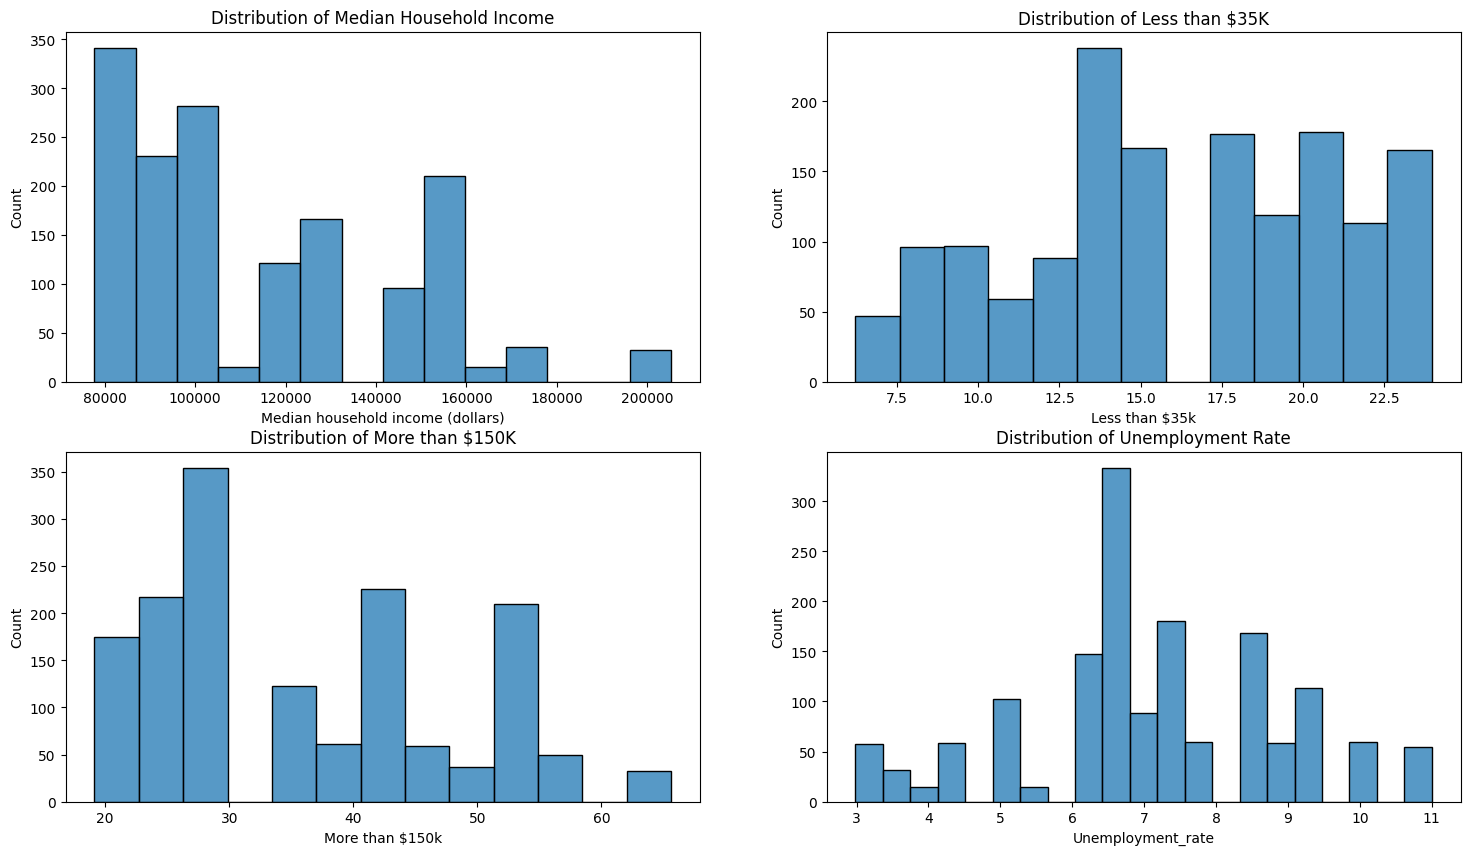

In [58]:
# plt.figure(figsize=(14, 6))
fig = plt.figure(figsize=[18,10]).tight_layout()

plt.subplot(2,2,1)
ax = sns.histplot(master_master['Median household income (dollars)'])
ax.set_title('Distribution of Median Household Income', fontsize=12)

plt.subplot(2,2,2)
ax = sns.histplot(master_master['Less than $35k'])
ax.set_title('Distribution of Less than $35K', fontsize=12)

plt.subplot(2,2,3)
ax = sns.histplot(master_master['More than $150k'])
ax.set_title('Distribution of More than $150K', fontsize=12)

plt.subplot(2,2,4)
ax = sns.histplot(master_master['Unemployment_rate'])
ax.set_title('Distribution of Unemployment Rate', fontsize=12)


Text(0.5, 1.0, 'Distribution of 18_24 Bachelor+')

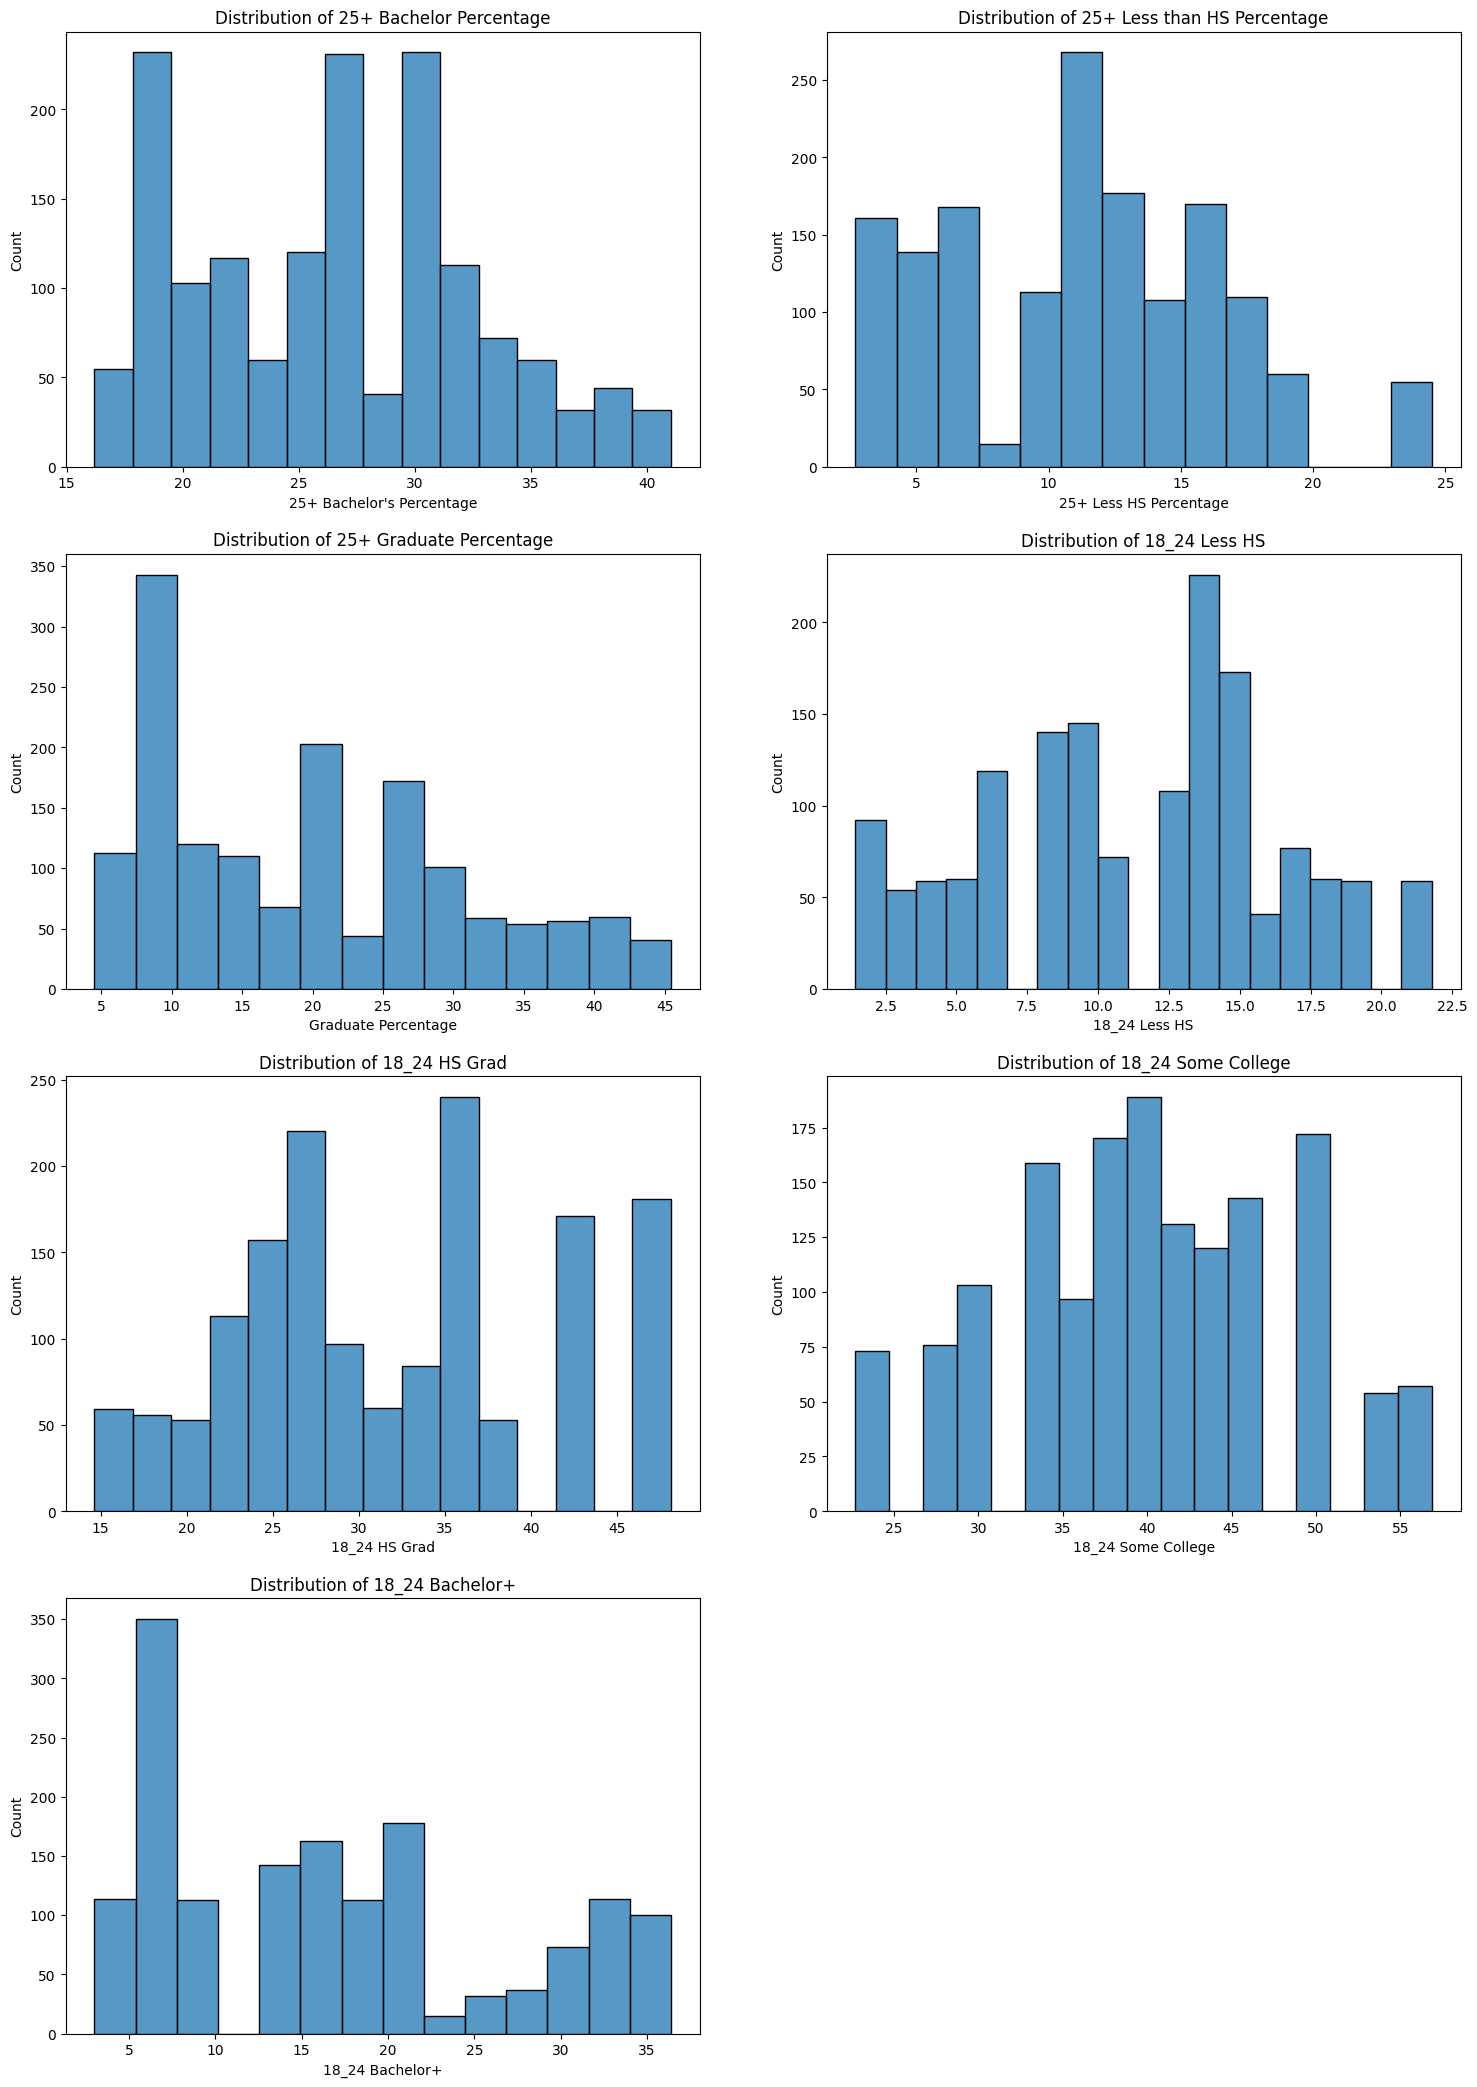

In [59]:
fig = plt.figure(figsize=[18,26]).tight_layout()

plt.subplot(4,2,1)
ax = sns.histplot(master_master["25+ Bachelor's Percentage"])
ax.set_title('Distribution of 25+ Bachelor Percentage', fontsize=12)

plt.subplot(4,2,2)
ax = sns.histplot(master_master['25+ Less HS Percentage'])
ax.set_title('Distribution of 25+ Less than HS Percentage', fontsize=12)

plt.subplot(4,2,3)
ax = sns.histplot(master_master['Graduate Percentage'])
ax.set_title('Distribution of 25+ Graduate Percentage', fontsize=12)

plt.subplot(4,2,4)
ax = sns.histplot(master_master['18_24 Less HS'])
ax.set_title('Distribution of 18_24 Less HS', fontsize=12)

plt.subplot(4,2,5)
ax = sns.histplot(master_master['18_24 HS Grad'])
ax.set_title('Distribution of 18_24 HS Grad', fontsize=12)

plt.subplot(4,2,6)
ax = sns.histplot(master_master['18_24 Some College'])
ax.set_title('Distribution of 18_24 Some College', fontsize=12)

plt.subplot(4,2,7)
ax = sns.histplot(master_master['18_24 Bachelor+'])
ax.set_title('Distribution of 18_24 Bachelor+', fontsize=12)


<Axes: >

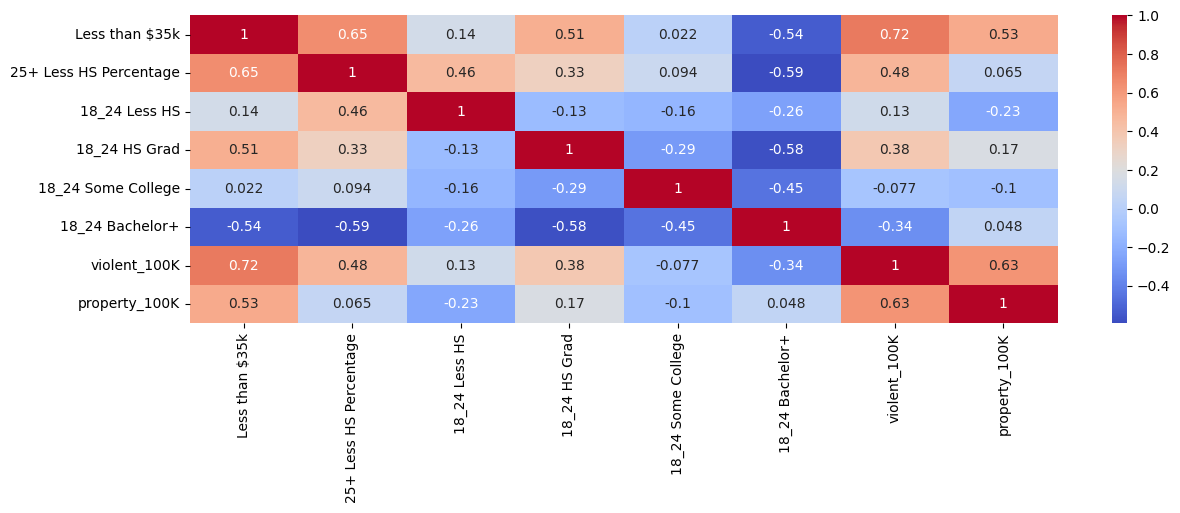

In [60]:
plt.figure(figsize=(14, 4))
corr_matrix = master_master.drop(columns=['Month', 'Median household income (dollars)', 'More than $150k', "25+ Bachelor's Percentage", 'Graduate Percentage', 'Unemployment_rate']).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

In [61]:
# features most correlated to violent:
##  18-24 HS grad, 25+ Less HS Percentage, Unemployment Rate, Less than $35K, 

# fetaures most related to property:
##  Unemployment rate, less than 35K, 18-24 HS grad

In [62]:
master_dummies = master_dummies.drop(columns=['Median household income (dollars)', 'More than $150k', "25+ Bachelor's Percentage", 'Graduate Percentage', 'Unemployment_rate'])

# master_dummies = pd.get_dummies(master_master, columns=['Month'])
# master_dummies.head()

# master_dummies = master_dummies.drop(columns=['Median household income (dollars)', 'More than $150k', "25+ Bachelor's Percentage", 'Graduate Percentage'])

master_dummies.head()

# master_final = master_master.drop(columns=['Month', 'Median household income (dollars)', 'More than $150k', "25+ Bachelor's Percentage", 'Graduate Percentage', 'Unemployment_rate'])
# master_final

,Less than $35k,25+ Less HS Percentage,18_24 Less HS,18_24 HS Grad,18_24 Some College,18_24 Bachelor+,violent_100K,property_100K,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,14.50,5.55,3.90,48.13,33.45,14.52,16.61,252.94,1,0,0,0,0,0,0,0,0,0,0,0
1,14.50,5.55,3.90,48.13,33.45,14.52,26.83,172.46,0,1,0,0,0,0,0,0,0,0,0,0
2,14.50,5.55,3.90,48.13,33.45,14.52,31.94,189.06,0,0,0,1,0,0,0,0,0,0,0,0
3,14.50,5.55,3.90,48.13,33.45,14.52,17.88,247.83,0,0,0,0,1,0,0,0,0,0,0,0
4,14.50,5.55,3.90,48.13,33.45,14.52,22.99,250.38,0,0,0,0,0,1,0,0,0,0,0,0


# ML Model Development + Evaluation

In [260]:
y_violent = master_dummies['violent_100K']
y_prop = master_dummies['property_100K']

x_both = master_dummies.drop(columns=['violent_100K', 'property_100K'])

x_train_v, x_test_v, y_train_v, y_test_v = train_test_split(x_both, y_violent, train_size = 0.8, random_state = 1)
x_train_p, x_test_p, y_train_p, y_test_p = train_test_split(x_both, y_prop, train_size = 0.8, random_state = 1)

## Linear Regression Model


Violent Train score:  0.729
Violent Test score:  0.761

Property Train score:  0.753
Property Test score:  0.776 



Text(0.5, 1.0, 'Property Crime Prediction vs Actuals')

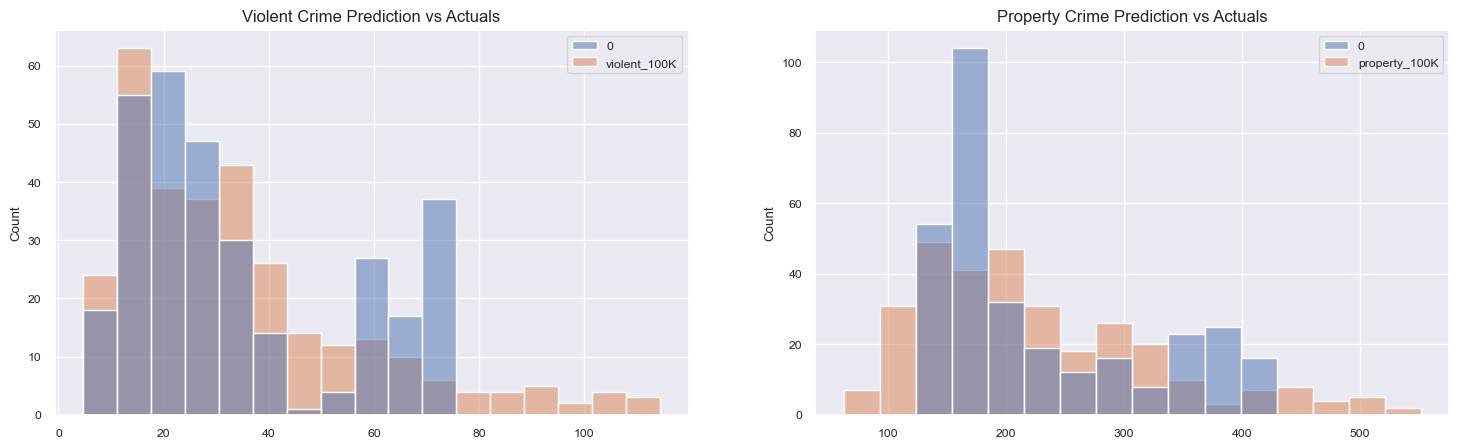

In [261]:
fig = plt.figure(figsize=[18,5])

lr_violent = LinearRegression()
lr_violent.fit(x_train_v, y_train_v)

print('\nViolent Train score: ',lr_violent.score(x_train_v, y_train_v).round(3))
print('Violent Test score: ',lr_violent.score(x_test_v, y_test_v).round(3))

lr_prop = LinearRegression()
lr_prop.fit(x_train_p, y_train_p)

print('\nProperty Train score: ',lr_prop.score(x_train_p, y_train_p).round(3))
print('Property Test score: ',lr_prop.score(x_test_p, y_test_p).round(3), '\n')

# predictions & evaluation

y_pred_v = lr_violent.predict(x_test_v)
y_pred_p = lr_prop.predict(x_test_p)

plt.subplot(1,2,1)
ax = sns.histplot([y_pred_v,y_test_v])
ax.set_title('Violent Crime Prediction vs Actuals', fontsize=12)

plt.subplot(1,2,2)
ax = sns.histplot([y_pred_p,y_test_p])
ax.set_title('Property Crime Prediction vs Actuals', fontsize=12)

# Decision Tree Regression


Violent Train score:  0.949
Violent Test score:  0.891

Property Train score:  0.924
Property Test score:  0.851 



Text(0.5, 1.0, 'Property Crime Prediction vs Actuals')

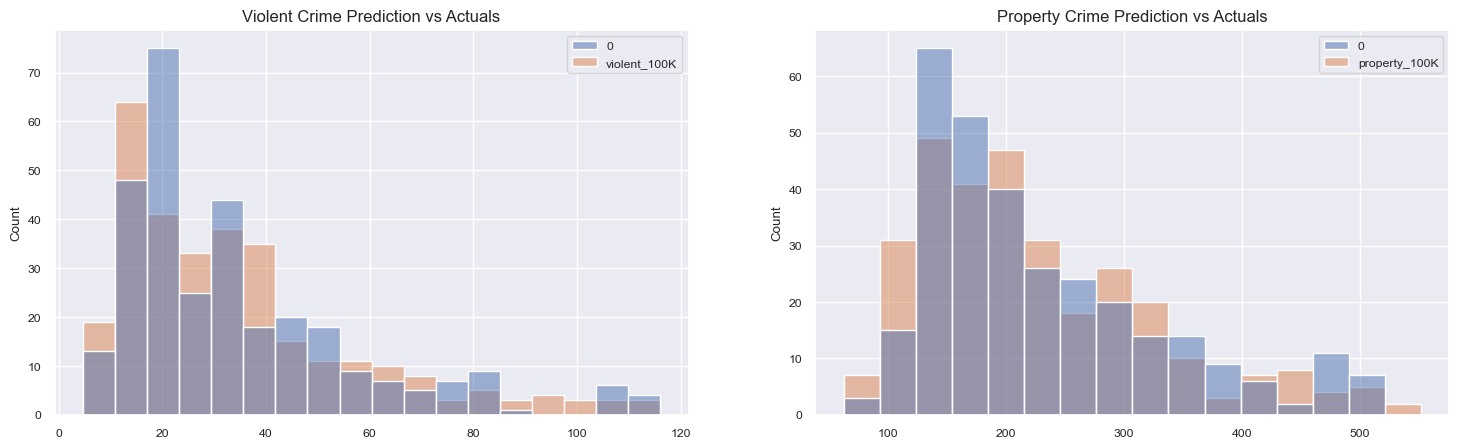

In [262]:
fig = plt.figure(figsize=[18,5])

dtr_v = DecisionTreeRegressor()
dtr_v.fit(x_train_v, y_train_v)

print('\nViolent Train score: ',dtr_v.score(x_train_v, y_train_v).round(3))
print('Violent Test score: ',dtr_v.score(x_test_v, y_test_v).round(3))

dtr_p = DecisionTreeRegressor()
dtr_p.fit(x_train_p, y_train_p)

print('\nProperty Train score: ',dtr_p.score(x_train_p, y_train_p).round(3))
print('Property Test score: ',dtr_p.score(x_test_p, y_test_p).round(3), '\n')

# predictions & evaluation

y_pred_v = dtr_v.predict(x_test_v)
y_pred_p = dtr_p.predict(x_test_p)

plt.subplot(1,2,1)
ax = sns.histplot([y_pred_v,y_test_v])
ax.set_title('Violent Crime Prediction vs Actuals', fontsize=12)

plt.subplot(1,2,2)
ax = sns.histplot([y_pred_p,y_test_p])
ax.set_title('Property Crime Prediction vs Actuals', fontsize=12)

# Random Forest Regression


Violent Train score:  0.948
Violent Test score:  0.902

Property Train score:  0.921
Property Test score:  0.874 



Text(0.5, 1.0, 'Property Crime Prediction vs Actuals')

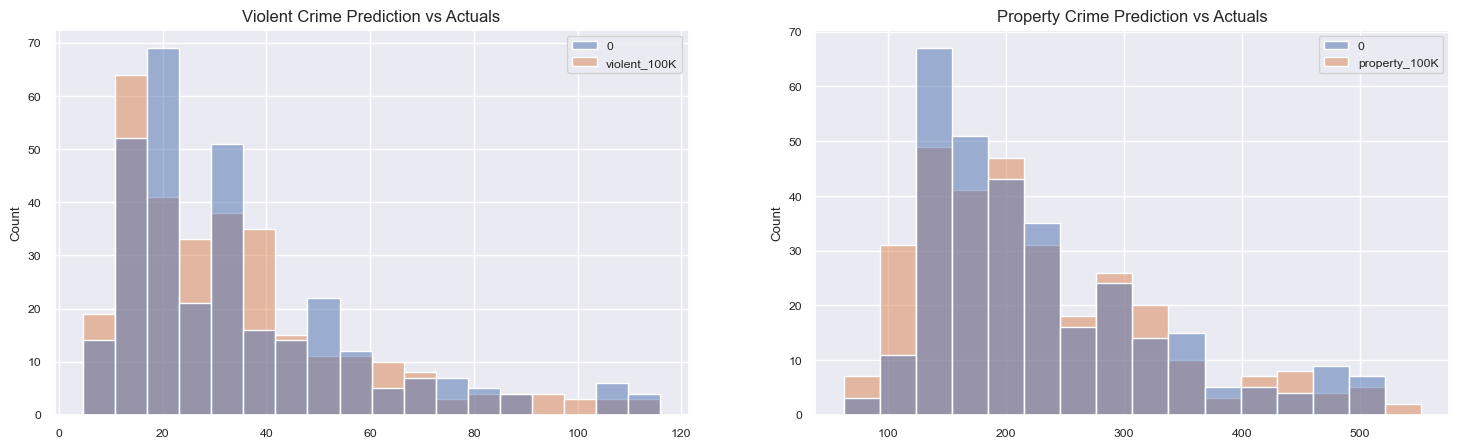

In [263]:
fig = plt.figure(figsize=[18,5])

rfr_v = RandomForestRegressor()
rfr_v.fit(x_train_v, y_train_v)

print('\nViolent Train score: ',rfr_v.score(x_train_v, y_train_v).round(3))
print('Violent Test score: ',rfr_v.score(x_test_v, y_test_v).round(3))

rfr_p = RandomForestRegressor()
rfr_p.fit(x_train_p, y_train_p)

print('\nProperty Train score: ',rfr_p.score(x_train_p, y_train_p).round(3))
print('Property Test score: ',rfr_p.score(x_test_p, y_test_p).round(3), '\n')

# predictions & evaluation

y_pred_v = rfr_v.predict(x_test_v)
y_pred_p = rfr_p.predict(x_test_p)

plt.subplot(1,2,1)
ax = sns.histplot([y_pred_v,y_test_v])
ax.set_title('Violent Crime Prediction vs Actuals', fontsize=12)

plt.subplot(1,2,2)
ax = sns.histplot([y_pred_p,y_test_p])
ax.set_title('Property Crime Prediction vs Actuals', fontsize=12)

# II.  Convert target variables to categorical and build + train classifiers

Text(0.5, 1.0, 'Property Crime Distribution')

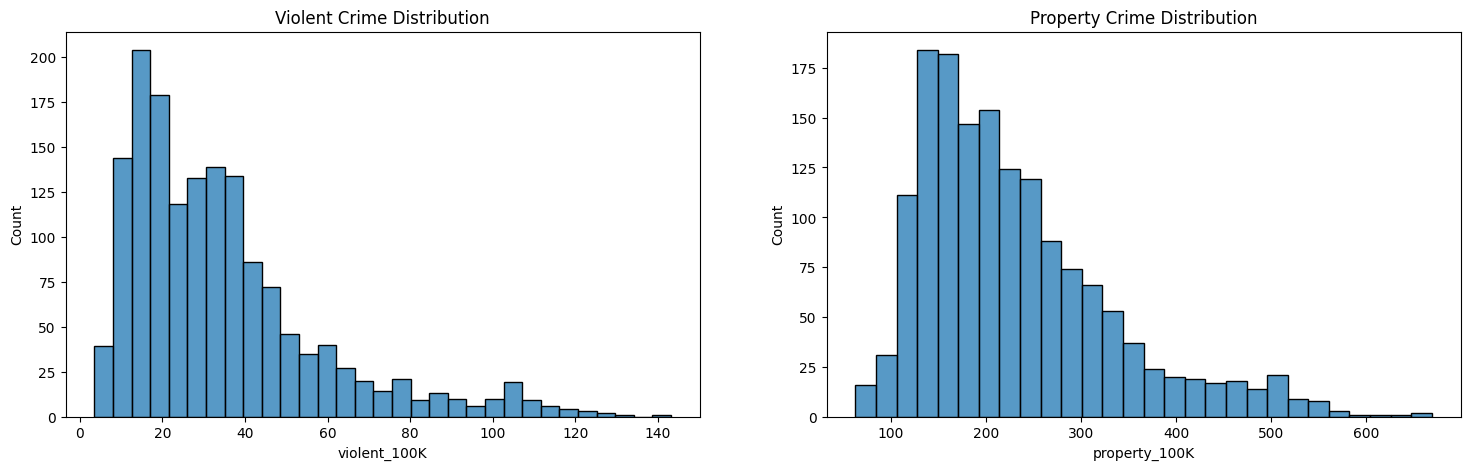

In [67]:
fig = plt.figure(figsize=[18,5])

plt.subplot(1,2,1)
ax = sns.histplot(master_dummies['violent_100K'])
ax.set_title('Violent Crime Distribution', fontsize=12)

plt.subplot(1,2,2)
ax = sns.histplot(master_dummies['property_100K'])
ax.set_title('Property Crime Distribution', fontsize=12)



In [68]:
master_dummies['violent_100K'].describe()

count   1,544.00
mean       34.50
std        23.56
min         3.55
25%        17.04
50%        29.20
75%        43.23
max       143.20
Name: violent_100K, dtype: float64

In [69]:
master_dummies['property_100K'].describe()

count   1,544.00
mean      230.26
std       101.92
min        62.64
25%       153.11
50%       206.60
75%       279.96
max       669.24
Name: property_100K, dtype: float64

In [70]:
# convert continuous target variables to categorical bases on distributions above

master_dummies['high_violent'] = [1 if x > 40 else 0 for x in master_dummies['violent_100K']]
master_dummies['high_property'] = [1 if x > 250 else 0 for x in master_dummies['property_100K']]

master_dummies.head()

,Less than $35k,25+ Less HS Percentage,18_24 Less HS,18_24 HS Grad,18_24 Some College,18_24 Bachelor+,violent_100K,property_100K,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,high_violent,high_property
0,14.50,5.55,3.90,48.13,33.45,14.52,16.61,252.94,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,14.50,5.55,3.90,48.13,33.45,14.52,26.83,172.46,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,14.50,5.55,3.90,48.13,33.45,14.52,31.94,189.06,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,14.50,5.55,3.90,48.13,33.45,14.52,17.88,247.83,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,14.50,5.55,3.90,48.13,33.45,14.52,22.99,250.38,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [71]:
y_violent = master_dummies['high_violent']
y_prop = master_dummies['high_property']

x_both = master_dummies.drop(columns=['violent_100K', 'property_100K', 'high_violent', 'high_property'])

x_train_v, x_test_v, y_train_v, y_test_v = train_test_split(x_both, y_violent, train_size = 0.8, random_state = 1)
x_train_p, x_test_p, y_train_p, y_test_p = train_test_split(x_both, y_prop, train_size = 0.8, random_state = 1)

# Logistic Regression


Violent Train score:  0.879
Violent Test score:  0.896

Property Train score:  0.817
Property Test score:  0.825 


 [[204  19]
 [ 13  73]]

 [[192  18]
 [ 36  63]] 



Text(0.5, 1.0, 'Property Crime Prediction vs Actuals')

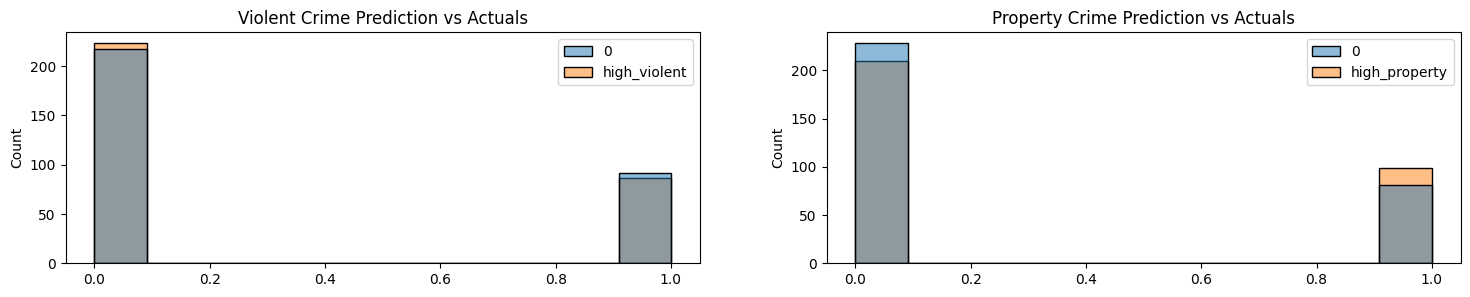

In [72]:
fig = plt.figure(figsize=[18,3])

logreg_violent = LogisticRegression()
logreg_violent.fit(x_train_v, y_train_v)

print('\nViolent Train score: ',logreg_violent.score(x_train_v, y_train_v).round(3))
print('Violent Test score: ',logreg_violent.score(x_test_v, y_test_v).round(3))

logreg_prop = LogisticRegression()
logreg_prop.fit(x_train_p, y_train_p)

print('\nProperty Train score: ',logreg_prop.score(x_train_p, y_train_p).round(3))
print('Property Test score: ',logreg_prop.score(x_test_p, y_test_p).round(3), '\n')

y_pred_v = logreg_violent.predict(x_test_v)
y_pred_p = logreg_prop.predict(x_test_p)

print('\n',confusion_matrix(y_test_v, y_pred_v))
print('\n',confusion_matrix(y_test_p, y_pred_p), '\n')

plt.subplot(1,2,1)
ax = sns.histplot([y_pred_v,y_test_v])
ax.set_title('Violent Crime Prediction vs Actuals', fontsize=12)

plt.subplot(1,2,2)
ax = sns.histplot([y_pred_p,y_test_p])
ax.set_title('Property Crime Prediction vs Actuals', fontsize=12)

# Random Forest Classifier


Violent Train score:  0.926
Violent Test score:  0.867

Property Train score:  0.916
Property Test score:  0.864 


 [[199  24]
 [ 17  69]]

 [[185  25]
 [ 17  82]] 



Text(0.5, 1.0, 'Property Crime Prediction vs Actuals')

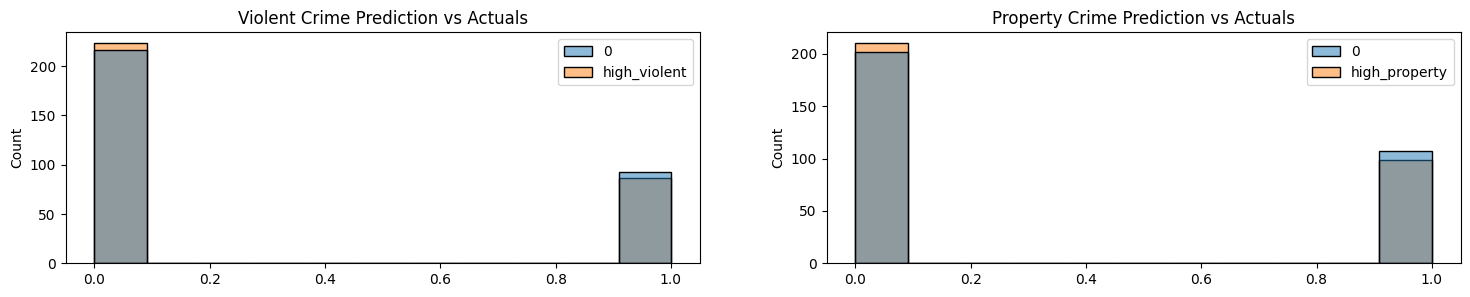

In [73]:
fig = plt.figure(figsize=[18,3])

clf_v = RandomForestClassifier(random_state=0)
clf_v.fit(x_train_v, y_train_v)

print('\nViolent Train score: ',clf_v.score(x_train_v, y_train_v).round(3))
print('Violent Test score: ',clf_v.score(x_test_v, y_test_v).round(3))

clf_p = RandomForestClassifier(random_state=0)
clf_p.fit(x_train_p, y_train_p)

print('\nProperty Train score: ',clf_p.score(x_train_p, y_train_p).round(3))
print('Property Test score: ',clf_p.score(x_test_p, y_test_p).round(3), '\n')

y_pred_v = clf_v.predict(x_test_v)
y_pred_p = clf_p.predict(x_test_p)

print('\n',confusion_matrix(y_test_v, y_pred_v))
print('\n',confusion_matrix(y_test_p, y_pred_p), '\n')

plt.subplot(1,2,1)
ax = sns.histplot([y_pred_v,y_test_v])
ax.set_title('Violent Crime Prediction vs Actuals', fontsize=12)

plt.subplot(1,2,2)
ax = sns.histplot([y_pred_p,y_test_p])
ax.set_title('Property Crime Prediction vs Actuals', fontsize=12)

# Gradient Boosting Classifier


Violent Train score:  0.918
Violent Test score:  0.88

Property Train score:  0.905
Property Test score:  0.893 


 [[202  21]
 [ 16  70]]

 [[195  15]
 [ 18  81]] 



Text(0.5, 1.0, 'Property Crime Prediction vs Actuals')

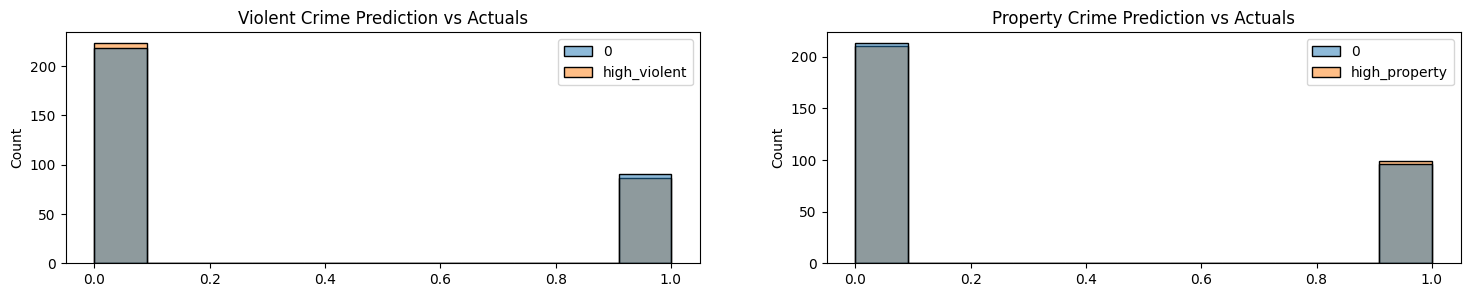

In [74]:
fig = plt.figure(figsize=[18,3])

xgb_v = GradientBoostingClassifier()
xgb_v.fit(x_train_v, y_train_v)

print('\nViolent Train score: ',xgb_v.score(x_train_v, y_train_v).round(3))
print('Violent Test score: ',xgb_v.score(x_test_v, y_test_v).round(3))

xgb_p = GradientBoostingClassifier()
xgb_p.fit(x_train_p, y_train_p)

print('\nProperty Train score: ',xgb_p.score(x_train_p, y_train_p).round(3))
print('Property Test score: ',xgb_p.score(x_test_p, y_test_p).round(3), '\n')

y_pred_v = xgb_v.predict(x_test_v)
y_pred_p = xgb_p.predict(x_test_p)

print('\n',confusion_matrix(y_test_v, y_pred_v))
print('\n',confusion_matrix(y_test_p, y_pred_p), '\n')

plt.subplot(1,2,1)
ax = sns.histplot([y_pred_v,y_test_v])
ax.set_title('Violent Crime Prediction vs Actuals', fontsize=12)

plt.subplot(1,2,2)
ax = sns.histplot([y_pred_p,y_test_p])
ax.set_title('Property Crime Prediction vs Actuals', fontsize=12)

# Discussion:

Leveraging publicly available monthly crime data across 5 years and socioeconomic data as of 2020, I was able to generate several regression and classification models that performed highly with the training datasets. 

Socioeconomic factors such as percentage of working households making less than $35K a year, percentage of the population with advanced degrees (or below a high school diploma), and unemployment rates can be used to predict per-capita violent and property crime rates to a reasonable degree.  As cities and towns across the country have been grappling with increasing crime in recent years, it is important to understand some of the key socioeconomic factors that are associated with, and may be responsible for some of the higher-crime areas such as the San Francisco Bay Area.

There were a few limitations to this research, one being the use of 2020 socioeconomic data across all 5 years of crime data. An improved methodology would be to obtain additional city-level socioeconomic data that is reported more frequently, or to extrapolate the estimated population each year based on historical trends. Additionally, transformation could have been performed on the target variables given the skew in the distribution.